In [1]:
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import logging
import numpy as np
import re 

from project.dataset import Dataset, VALDODataset
from project.preprocessing import z_score_normalization, min_max_normalization, NiftiToTensorTransform
from project.training import split_train_val_datasets
from project.utils import collate_fn, plot_all_slices, plot_all_slices_from_array
from torch.utils.data import DataLoader
from project.model import VisionTransformer
from torch.optim import Adam
from project.model.fitter import Fitter
from matplotlib import pyplot as plt
from tqdm import tqdm

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.16 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


#### Setup logging

In [2]:
dir_path = 'experiments/'

if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    
file_num = len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])

In [3]:
# log_dir = 'vit_test_logs'
# filename_log = f'{log_dir}/training_log_Vit{file_num + 1}.log'

# # Ensure the log directory exists
# if not os.path.exists(log_dir):
#     os.makedirs(log_dir)

# # Configure logging to log to the specified file
# logging.basicConfig(filename=filename_log, level=logging.INFO)

In [4]:
d_model = 2
n_classes = 2
img_size = (16,16)
patch_size = (2,2)
n_channels = 1
n_heads = 2
n_layers = 3
batch_size = 1
epochs = 3
alpha = 0.000125

In [5]:
Moddel_info= f'Creating model with d_model={d_model}, n_classes={n_classes}, img_size={img_size}, patch_size={patch_size}, n_channels={n_channels}, n_heads={n_heads}, n_layers={n_layers}, batch_size={batch_size}, epochs={epochs}, alpha={alpha}'
logging.info(Moddel_info)

INFO:root:Creating model with d_model=2, n_classes=2, img_size=(16, 16), patch_size=(2, 2), n_channels=1, n_heads=2, n_layers=3, batch_size=1, epochs=3, alpha=0.000125


In [6]:
ds = Dataset()

In [7]:
# masks = ds.load_cmb_masks()
# cases = ds.load_raw_mri()
# cases = ds.load_skullstripped_mri(cohort_num=1)

# masks = ds.load_cmb_masks(cohort_num=1)
# cases = ds.load_raw_mri(cohort_num=1)

cases = ds.load_skullstripped_mri()
masks = ds.load_cmb_masks()

In [8]:
transform = NiftiToTensorTransform(target_shape=(512,512))

In [9]:
dataset = VALDODataset(
    cases=cases, 
    masks=masks, 
    transform=transform,
    normalization=z_score_normalization
)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [10]:
sample_output = [
    
]

#1asdf

In [11]:
print(type(dataset))
print(len(dataset))

<class 'project.dataset.valdo.VALDODataset'>
72


In [12]:
has_cmb = [1 if count > 0 else 0 for count in dataset.cmb_counts]

df_dataset = pd.DataFrame({
    'MRI Scans': dataset.cases,
    'Segmented Masks': dataset.masks,
    'CMB Count': dataset.cmb_counts,
    'Has CMB': has_cmb
})

In [13]:
train_dataset, val_dataset = split_train_val_datasets(
    df=df_dataset, 
    transform=transform
)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [14]:
train_loader = DataLoader(
    train_dataset, 
    shuffle=True, 
    batch_size=batch_size,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset, 
    shuffle=True, 
    batch_size=batch_size,
    collate_fn=collate_fn
)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [16]:
transformer = VisionTransformer(
    D_model=d_model,
    N_classes=n_classes,
    Img_size=img_size,
    Patch_size=patch_size,
    N_channels=n_channels,
    N_heads=n_heads,
    N_layers=n_layers,
    device=device
)

In [17]:
transformer = transformer.to(device)

In [18]:
optimizer = Adam(transformer.parameters(), lr=alpha)
criterion = nn.CrossEntropyLoss()

In [19]:
import matplotlib.pyplot as plt
def print_image(img, title):
    plt.imshow(img, cmap='hot')
    plt.title(title)
    plt.show()

In [20]:
class ViTFitter(Fitter):
    def train_one_epoch(self, train_loader):
        self.model.train()
        loss_history = []
        for case in train_loader:
            if torch.unique(case[1]).numel() > 1:
                num_slices= len(case[1]) # Number of slices
                case_number = re.search(r'sub-(\d+)', case[2][0]).group(1) # Extract the case number
                # print(f'Case: {case_number}')
                logging.info(f'Training with Case: {case_number}')
                if num_slices != len(case[0]):
                    # print('Not equal Number of slices:', num_slices, data[0]) #Checks if the number of slices of the MRI and the mask are the same
                    logging.error(f'Not equal Number of slices: {num_slices} MRI: {len(case[0])} Mask: {len(data[1])}')
                    break
                for j in range(num_slices):
                    bounding_boxes = dataset.extract_bounding_boxes(case[1][j][0].numpy()) #Extracts all the bounding boxes of the slice 
                    cropped_images = []
                    cropped_labels = []
                    coordinates = []
                    if len(bounding_boxes) <= 0: # If there are no bounding boxes then it will skip the slice
                        # print('No bounding boxes found on slice ', j)
                        logging.warning(f'No bounding boxes found on slice {j}')
                        continue
                    for bbox in bounding_boxes: # For each bounding box it will crop the image and the label based on the given coordinates
                        # print(f"Slice {j} | ", bbox) 
                        logging.info(f'Slice {j} | {bbox}')
                        # print(data[0][j][0].shape)
                        logging.info(f'Image shape: {case[0][j][0].shape}')
                        cropped_images.append(
                            dataset.get_cropped_locations(
                                img = case[0], 
                                x_min=bbox[0],
                                y_min=bbox[1],
                                x_max=bbox[2],
                                y_max=bbox[3]
                            ))
                        cropped_labels.append(
                            dataset.get_cropped_locations(
                                img = case[1], 
                                x_min=bbox[0],
                                y_min=bbox[1],
                                x_max=bbox[2],
                                y_max=bbox[3]
                            ))
                        coordinates.append(bbox)
                    if len(cropped_images[0][0][0]) != len(cropped_labels[0][0]): ## Checks if the number of cropped images and labels are the same
                        print('Not equal cropped images and labels')
                        logging.error(f'Not equal cropped images and labels')    
                        break

                        # TODO: Improve this method since the method requires all the slices therefore it is needed to have another loop that checks if the extracted region has a cmb or not before feeding it into the model
                    # print('Cropped Images length:', len(cropped_images))
                    # print('Cropped Labels length:', len(cropped_labels))
                    # print('Cropped Images number of slices:', len(cropped_images[0][0][0])) # This is the MRI image of the CMB with the coordinate
                    # print('Cropped Labels number of slices:', len(cropped_labels[0][0])) # This is the mask of the CMB with the coordinate
                    logging.info(f'Cropped Images length: {len(cropped_images)}')
                    logging.info(f'Cropped Labels length: {len(cropped_labels)}')
                    logging.info(f'Cropped Images number of slices: {len(cropped_images[0][0][0])}')
                    logging.info(f'Cropped Labels number of slices: {len(cropped_labels[0][0])}')
                    for k, cmb in enumerate(cropped_labels[0]): # Access the CMB labels array the n checks if there are CMBs on the slice of the case 
                         for l, cmb_slice in enumerate(cmb):
                            # print(cmb_slice.shape)
                            if torch.unique(cmb_slice).numel() > 1:
                                # print('Multiple classes found on silce: ', l)
                                # print(cmb_slice.shape)
                                # print(cropped_images[0][0][0][l].shape)
                                logging.info(f'Multiple classes found on slice: {l}')
                                logging.info(f'Mask shape: {cmb_slice.shape}')
                                logging.info(f'Image shape: {cropped_images[0][0][0][l].shape}')
                                # Enable ths method to visually see what is feeded on the model 
                                # print_image(cropped_images[0][0][0][l], f'MRI Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                                # print_image(cmb_slice, f'Mask Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                                # print(f'Learning on Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                                logging.info(f'MRI Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                                logging.info(f'Mask Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                                logging.info(f'Learning on Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                                optimizer.zero_grad()
                                inputs = cropped_images[0][0][0][l].unsqueeze(0).unsqueeze(0).to(device)
                                labels = cropped_labels[0][0][l].unsqueeze(0).to(device)
                                # print("Feeded inputs shape: ",inputs.shape)
                                # print("Feeded mask shape: ",labels.shape)
                                logging.info(f'Feeded inputs shape: {inputs.shape}')
                                logging.info(f'Feeded mask shape: {labels.shape}')
                                outputs = transformer(inputs.float(), labels.float())
                                loss = criterion(outputs, labels.long())  
                                # print("Output shape: ",outputs.shape)
                                logging.info(f'Output shape: {outputs.shape}')
                                loss.backward()
                                optimizer.step()
                                loss_history.append(loss.item())
                                logging.info(f'Loss: {loss.item()}')
                print("Training Loss: ", loss_history[-1]) # Prints the last loss of the epoch
            else:
                # print('Skipping case with no CMBs')
                logging.warning('Skipping case with no CMBs')
                continue
        return loss_history
    
    def validation(self, val_loader):
        def predict(model, image, mask):
            model.eval()
            with torch.no_grad():
                image = image.to(device)
                output = self.model(images = image, mask = mask)
                output = F.interpolate(output, size=img_size, mode='bilinear', align_corners=False)
                prediction = torch.argmax(output, dim=1)
            return prediction.cpu().numpy()
        loss_history = []
        with torch.no_grad():
            for val_batch in val_loader:
                num_slices = len(val_batch[1])#Number of slces
                one_case = []#This is where we store every slice of the case 
                case_number = re.search(r'sub-(\d+)', val_batch[2][0]).group(1) # Extract the case number
                one_case.append(case_number)

                # print(f'Validation with Case: {case_number}')
                logging.info(f'Validation with Case: {case_number}')
                if num_slices != len(val_batch[0]):
                    # print('Not equal Number of slices:', num_slices, val_batch[0])#Checks if the number of slices of the MRI and the mask are the same
                    logging.error(f'Not equal Number of slices: {num_slices} MRI: {len(val_batch[0])} Mask: {len(val_batch[1])}')
                    break
                for j in range(num_slices):
                    bounding_boxes = dataset.extract_bounding_boxes(val_batch[1][j][0].numpy())#Extracts all the bounding boxes of the slice
                    cropped_images = []
                    cropped_labels = []
                    coordinates = []
                    if len(bounding_boxes) > 0: # If there are no bounding boxes then it will skip the slice
                        # print('No bounding boxes found on slice ', j)
                        logging.warning(f'No bounding boxes found on slice {j}')
                        for bbox in bounding_boxes: #For each bounding box it will crop the image and the label based on the given 
                            # print(f"Slice {j} | ", bbox)
                            logging.info(f'Slice {j} | {bbox}')
                            print(val_batch[0][j][0].shape)
                            cropped_images.append(
                                dataset.get_cropped_locations(
                                    img = val_batch[0], 
                                    x_min=bbox[0],
                                    y_min=bbox[1],
                                    x_max=bbox[2],
                                    y_max=bbox[3]
                                ))
                            cropped_labels.append(
                                dataset.get_cropped_locations(
                                    img = val_batch[1], 
                                    x_min=bbox[0],
                                    y_min=bbox[1],
                                    x_max=bbox[2],
                                    y_max=bbox[3]
                                ))
                            coordinates.append(bbox)
                        if len(cropped_images[0][0][0]) != len(cropped_labels[0][0]):## Checks if the number of cropped images and labels are the same
                            # print('Not equal cropped images and labels')
                            logging.error(f'Not equal cropped images and labels')
                            break
                        # TODO: Improve this method since the method requires all the slices therefore it is needed to have another loop that checks if the extracted region has a cmb or not before feeding it into the model
                        for k, cmb in enumerate(cropped_labels[0]):# Access the CMB labels array the n checks if there are CMBs on the slice of the case
                            for l, cmb_slice in enumerate(cmb):
                                if torch.unique(cmb_slice).numel() > 1:
                                    # print(f'Predicting on Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                                    logging.info(f'Predicting on Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                                    inputs = cropped_images[0][0][0][l].unsqueeze(0).unsqueeze(0).to(device)
                                    labels = cropped_labels[0][0][l].unsqueeze(0).to(device)
                                    predicted_mask = predict(transformer, image = inputs.float(), mask = labels.float().to(device))
                                    predicted_mask = torch.tensor(predicted_mask).to(device)
                                    loss = criterion(predicted_mask.float(), labels.float())
                                    loss_history.append(loss.item())
            return loss_history 

In [21]:
fitter = ViTFitter(model = transformer, epochs=epochs, optim=optimizer, loss=criterion, device=device)

In [22]:
import os

# Create the directory if it doesn't exist
save_dir = 'experiments/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [23]:
hist = fitter.fit(train_loader, val_loader, file_num)

INFO:root:Training with Case: 107
INFO:root:Slice 13 | [154, 205, 157, 209]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 35
INFO:root:Cropped Labels number of slices: 35
INFO:root:Multiple classes found on slice: 13
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 107 Slice 13 CMB coordinates [154, 205, 157, 209]
INFO:root:Mask Case 107 Slice 13 CMB coordinates [154, 205, 157, 209]
INFO:root:Learning on Case 107 Slice 13 CMB coordinates [154, 205, 157, 209]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 8.172111511230469
INFO:root:Slice 23 | [162, 169, 167, 174]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:ro

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(8.1721, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(6.5954, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


Training Loss:  6.595417499542236


INFO:root:Training with Case: 317
INFO:root:Slice 31 | [156, 284, 160, 290]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 48
INFO:root:Cropped Labels number of slices: 48
INFO:root:Multiple classes found on slice: 31
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 317 Slice 31 CMB coordinates [156, 284, 160, 290]
INFO:root:Mask Case 317 Slice 31 CMB coordinates [156, 284, 160, 290]
INFO:root:Learning on Case 317 Slice 31 CMB coordinates [156, 284, 160, 290]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 3.2478601932525635


Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(3.2479, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Training Loss:  3.2478601932525635


INFO:root:Training with Case: 223
INFO:root:Slice 27 | [207, 238, 209, 241]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 29
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 223 Slice 29 CMB coordinates [207, 238, 209, 241]
INFO:root:Mask Case 223 Slice 29 CMB coordinates [207, 238, 209, 241]
INFO:root:Learning on Case 223 Slice 29 CMB coordinates [207, 238, 209, 241]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 220.83340454101562
INFO:root:Multiple classes found on slice: 30
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 223 Slice 30 

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(220.8334, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(116.8967, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(506.9408, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(230.0685, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


INFO:root:Loss: 230.0684814453125
INFO:root:Multiple classes found on slice: 30
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 223 Slice 30 CMB coordinates [207, 238, 209, 242]
INFO:root:Mask Case 223 Slice 30 CMB coordinates [207, 238, 209, 242]
INFO:root:Learning on Case 223 Slice 30 CMB coordinates [207, 238, 209, 242]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 183.5538330078125
INFO:root:Slice 29 | [208, 238, 211, 242]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 27
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 223 Slice 27 C

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(183.5538, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(121.2929, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(103.3473, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(335.7968, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 142.39096069335938
INFO:root:Multiple classes found on slice: 28
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 223 Slice 28 CMB coordinates [208, 240, 210, 242]
INFO:root:Mask Case 223 Slice 28 CMB coordinates [208, 240, 210, 242]
INFO:root:Learning on Case 223 Slice 28 CMB coordinates [208, 240, 210, 242]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 184.4395294189453


Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(142.3910, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(184.4395, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Training Loss:  184.4395294189453


INFO:root:Training with Case: 313
INFO:root:Slice 9 | [144, 212, 148, 218]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 39
INFO:root:Cropped Labels number of slices: 39
INFO:root:Multiple classes found on slice: 9
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 313 Slice 9 CMB coordinates [144, 212, 148, 218]
INFO:root:Mask Case 313 Slice 9 CMB coordinates [144, 212, 148, 218]
INFO:root:Learning on Case 313 Slice 9 CMB coordinates [144, 212, 148, 218]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 2.8312957286834717


Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(2.8313, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Training Loss:  2.8312957286834717


INFO:root:Training with Case: 221
INFO:root:Slice 76 | [134, 362, 137, 366]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 78
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 221 Slice 78 CMB coordinates [134, 362, 137, 366]
INFO:root:Mask Case 221 Slice 78 CMB coordinates [134, 362, 137, 366]
INFO:root:Learning on Case 221 Slice 78 CMB coordinates [134, 362, 137, 366]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 611.4444580078125
INFO:root:Slice 77 | [134, 362, 138, 366]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(611.4445, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(361.9871, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(599.2576, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(359.7424, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Slice 82 | [144, 356, 148, 360]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 82
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 221 Slice 82 CMB coordinates [144, 356, 148, 360]
INFO:root:Mask Case 221 Slice 82 CMB coordinates [144, 356, 148, 360]
INFO:root:Learning on Case 221 Slice 82 CMB coordinates [144, 356, 148, 360]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 565.3677368164062
INFO:root:Multiple classes found on slice: 83
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 221 Slice 83 CMB coordinates [144, 356, 148, 360

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(565.3677, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(333.5833, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(382.1645, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(650.7633, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Mask Case 221 Slice 85 CMB coordinates [144, 356, 148, 361]
INFO:root:Learning on Case 221 Slice 85 CMB coordinates [144, 356, 148, 361]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 609.756591796875
INFO:root:Slice 84 | [144, 356, 148, 360]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 82
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 221 Slice 82 CMB coordinates [144, 356, 148, 360]
INFO:root:Mask Case 221 Slice 82 CMB coordinates [144, 356, 148, 360]
INFO:root:Learning on Case 221 Slice 82 CMB coordinates [144, 356, 148, 360]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 1

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(609.7566, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(547.3997, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(324.2214, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(370.9776, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 448.56591796875
INFO:root:Multiple classes found on slice: 83
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 221 Slice 83 CMB coordinates [144, 356, 148, 361]
INFO:root:Mask Case 221 Slice 83 CMB coordinates [144, 356, 148, 361]
INFO:root:Learning on Case 221 Slice 83 CMB coordinates [144, 356, 148, 361]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 346.0948486328125
INFO:root:Multiple classes found on slice: 84
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 221 Slice 84 CMB coordinates [144, 356, 148, 361]
INFO:root:Mask Case 221 Slice 84 CMB coordinates [144, 356, 148, 361]
INFO:root:Learning on Case 221 Slice 84 CMB coordinates [144, 356, 148, 361]
INFO:root:Feeded inputs

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(448.5659, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(346.0948, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(331.0674, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(590.7814, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Mask Case 221 Slice 99 CMB coordinates [112, 324, 115, 328]
INFO:root:Learning on Case 221 Slice 99 CMB coordinates [112, 324, 115, 328]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 338.5792236328125
INFO:root:Slice 97 | [111, 324, 114, 328]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 96
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 221 Slice 96 CMB coordinates [111, 324, 114, 328]
INFO:root:Mask Case 221 Slice 96 CMB coordinates [111, 324, 114, 328]
INFO:root:Learning on Case 221 Slice 96 CMB coordinates [111, 324, 114, 328]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(338.5792, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(338.1959, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(415.4085, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(389.1296, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Loss: 411.09478759765625
INFO:root:Multiple classes found on slice: 99
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 221 Slice 99 CMB coordinates [111, 324, 114, 328]
INFO:root:Mask Case 221 Slice 99 CMB coordinates [111, 324, 114, 328]
INFO:root:Learning on Case 221 Slice 99 CMB coordinates [111, 324, 114, 328]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 385.0801086425781
INFO:root:Slice 99 | [112, 324, 114, 327]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Slice 107 | [298, 326, 301, 330]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INF

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(385.0801, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(462.4112, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(293.8240, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(419.2783, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Loss: 245.03125
INFO:root:Slice 109 | [299, 327, 302, 330]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 109 | [96, 324, 98, 327]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 2
INFO:root:Cropped Labels length: 2
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 107
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 221 Slice 107 CMB coordinates [299, 327, 302, 330]
INFO:root:Mask Case 221 Slice 107 CMB coordinates [299, 327, 302, 330]
INFO:root:Learning on Case 221 Slice 107 CMB coordinates [299, 327, 302, 330]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 261.9473876953125
INFO:root:Multiple classes found on slice: 108
INFO:root:Mask shape: torch.Size

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(261.9474, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(159.5265, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(392.4003, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(233.0012, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 221 Slice 112 CMB coordinates [95, 324, 99, 328]
INFO:root:Mask Case 221 Slice 112 CMB coordinates [95, 324, 99, 328]
INFO:root:Learning on Case 221 Slice 112 CMB coordinates [95, 324, 99, 328]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 243.49575805664062
INFO:root:Multiple classes found on slice: 113
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 221 Slice 113 CMB coordinates [95, 324, 99, 328]
INFO:root:Mask Case 221 Slice 113 CMB coordinates [95, 324, 99, 328]
INFO:root:Learning on Case 221 Slice 113 CMB coordinates [95, 324, 99, 328]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 245.2952423095703
INF

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(243.4958, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(245.2952, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(437.4837, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(257.2268, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Cropped Labels length: 2
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 109
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 221 Slice 109 CMB coordinates [95, 324, 99, 327]
INFO:root:Mask Case 221 Slice 109 CMB coordinates [95, 324, 99, 327]
INFO:root:Learning on Case 221 Slice 109 CMB coordinates [95, 324, 99, 327]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 298.85009765625
INFO:root:Multiple classes found on slice: 110
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 221 Slice 110 CMB coordinates [95, 324, 99, 327]
INFO:root:Mask Case 221 Slice 110 CMB coordinates [95, 324, 99, 327]
INFO:root:Learning on Case 221 Slice 110 CMB coordinates [9

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(298.8501, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(256.3999, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(154.1452, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(317.8098, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Loss: 373.99945068359375
INFO:root:Slice 114 | [104, 323, 106, 326]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 113
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 221 Slice 113 CMB coordinates [104, 323, 106, 326]
INFO:root:Mask Case 221 Slice 113 CMB coordinates [104, 323, 106, 326]
INFO:root:Learning on Case 221 Slice 113 CMB coordinates [104, 323, 106, 326]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 251.9248504638672
INFO:root:Slice 127 | [170, 328, 173, 331]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(251.9249, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(439.5272, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(287.9498, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(331.2105, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Loss: 220.45242309570312
INFO:root:Multiple classes found on slice: 130
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 221 Slice 130 CMB coordinates [170, 328, 173, 332]
INFO:root:Mask Case 221 Slice 130 CMB coordinates [170, 328, 173, 332]
INFO:root:Learning on Case 221 Slice 130 CMB coordinates [170, 328, 173, 332]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 423.17449951171875
INFO:root:Slice 129 | [170, 328, 173, 331]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 127
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 221 Sl

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(423.1745, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(432.2755, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(283.3772, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(429.7237, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 131
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 221 Slice 131 CMB coordinates [172, 317, 175, 321]
INFO:root:Mask Case 221 Slice 131 CMB coordinates [172, 317, 175, 321]
INFO:root:Learning on Case 221 Slice 131 CMB coordinates [172, 317, 175, 321]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 533.5535888671875
INFO:root:Multiple classes found on slice: 134
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 221 Slice 134 CMB coordinates [172, 317, 175, 321]
INFO:root:Mask Case 221 Slice 134 CMB coordinates [172, 317, 175, 321]
INFO:root:Learning on Case 221 Slice 134 CMB co

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(533.5536, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(343.8152, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(530.0012, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(341.7307, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Multiple classes found on slice: 133
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 221 Slice 133 CMB coordinates [171, 317, 175, 321]
INFO:root:Mask Case 221 Slice 133 CMB coordinates [171, 317, 175, 321]
INFO:root:Learning on Case 221 Slice 133 CMB coordinates [171, 317, 175, 321]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 573.8493041992188
INFO:root:Multiple classes found on slice: 134
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 221 Slice 134 CMB coordinates [171, 317, 175, 321]
INFO:root:Mask Case 221 Slice 134 CMB coordinates [171, 317, 175, 321]
INFO:root:Learning on Case 221 Slice 134 CMB coordinates [171, 317, 175, 321]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size(

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(573.8493, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(233.1170, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(165.4147, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(392.3629, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Multiple classes found on slice: 139
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 221 Slice 139 CMB coordinates [127, 304, 131, 308]
INFO:root:Mask Case 221 Slice 139 CMB coordinates [127, 304, 131, 308]
INFO:root:Learning on Case 221 Slice 139 CMB coordinates [127, 304, 131, 308]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 480.84271240234375
INFO:root:Slice 138 | [127, 303, 131, 309]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 136
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 221 Slice 136 CMB coordinates [127, 303, 

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(480.8427, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(130.7017, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(292.3938, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(427.3555, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 382.7279052734375
INFO:root:Multiple classes found on slice: 138
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 221 Slice 138 CMB coordinates [127, 304, 131, 308]
INFO:root:Mask Case 221 Slice 138 CMB coordinates [127, 304, 131, 308]
INFO:root:Learning on Case 221 Slice 138 CMB coordinates [127, 304, 131, 308]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 421.28704833984375
INFO:root:Multiple classes found on slice: 139
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 221 Slice 139 CMB coordinates [127, 304, 131, 308]
INFO:root:Mask Case 221 Slice 139 CMB coordinates 

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(382.7279, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(421.2870, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(469.4784, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(182.1995, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Slice 141 | [130, 286, 135, 290]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 139
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 221 Slice 139 CMB coordinates [130, 286, 135, 290]
INFO:root:Mask Case 221 Slice 139 CMB coordinates [130, 286, 135, 290]
INFO:root:Learning on Case 221 Slice 139 CMB coordinates [130, 286, 135, 290]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 180.1807861328125
INFO:root:Multiple classes found on slice: 140
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 221 Slice 140 CMB coordinates [130, 286, 1

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(180.1808, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(256.9383, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(224.5592, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(161.8779, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Multiple classes found on slice: 142
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 221 Slice 142 CMB coordinates [132, 286, 135, 290]
INFO:root:Mask Case 221 Slice 142 CMB coordinates [132, 286, 135, 290]
INFO:root:Learning on Case 221 Slice 142 CMB coordinates [132, 286, 135, 290]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 206.6521759033203
INFO:root:Slice 143 | [101, 279, 104, 282]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 143
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 221 Slice 143 CMB coordinates [101, 279, 1

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(206.6522, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(189.5752, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(189.1880, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Training Loss:  189.18804931640625


INFO:root:Training with Case: 326
INFO:root:Slice 24 | [382, 278, 388, 284]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 39
INFO:root:Cropped Labels number of slices: 39
INFO:root:Multiple classes found on slice: 24
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 326 Slice 24 CMB coordinates [382, 278, 388, 284]
INFO:root:Mask Case 326 Slice 24 CMB coordinates [382, 278, 388, 284]
INFO:root:Learning on Case 326 Slice 24 CMB coordinates [382, 278, 388, 284]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 2.5139060020446777
INFO:root:Multiple classes found on slice: 25
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 326 Slice 25 CM

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(2.5139, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.8845, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Training Loss:  0.8844925165176392


INFO:root:Training with Case: 217
INFO:root:Slice 86 | [285, 169, 289, 175]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 86
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 217 Slice 86 CMB coordinates [285, 169, 289, 175]
INFO:root:Mask Case 217 Slice 86 CMB coordinates [285, 169, 289, 175]
INFO:root:Learning on Case 217 Slice 86 CMB coordinates [285, 169, 289, 175]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 269.08673095703125
INFO:root:Multiple classes found on slice: 87
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 217 Slice 87 

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(269.0867, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(124.3688, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(171.8148, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(178.2215, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Multiple classes found on slice: 88
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 217 Slice 88 CMB coordinates [283, 170, 289, 174]
INFO:root:Mask Case 217 Slice 88 CMB coordinates [283, 170, 289, 174]
INFO:root:Learning on Case 217 Slice 88 CMB coordinates [283, 170, 289, 174]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 105.56452941894531
INFO:root:Multiple classes found on slice: 89
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 217 Slice 89 CMB coordinates [283, 170, 289, 174]
INFO:root:Mask Case 217 Slice 89 CMB coordinates [283, 170, 289, 174]
INFO:root:Learning on Case 217 Slice 89 CMB coordinates [283, 170, 289, 174]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16,

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(105.5645, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(214.9378, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(211.2676, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(141.6435, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Loss: 138.239990234375
INFO:root:Multiple classes found on slice: 87
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 217 Slice 87 CMB coordinates [283, 168, 290, 174]
INFO:root:Mask Case 217 Slice 87 CMB coordinates [283, 168, 290, 174]
INFO:root:Learning on Case 217 Slice 87 CMB coordinates [283, 168, 290, 174]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 119.87699127197266
INFO:root:Multiple classes found on slice: 88
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 217 Slice 88 CMB coordinates [283, 168, 290, 174]
INFO:root:Mask Case 217 Slice 88 CMB coordinates [283, 168, 290, 174]
INFO:root:Learning on Case 217 Slice 88 CMB coordinates [283, 168, 290, 174]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feed

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(119.8770, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(148.1119, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(191.7875, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Training Loss:  191.78750610351562


INFO:root:Training with Case: 218
INFO:root:Slice 54 | [179, 225, 182, 228]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 54
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 54 CMB coordinates [179, 225, 182, 228]
INFO:root:Mask Case 218 Slice 54 CMB coordinates [179, 225, 182, 228]
INFO:root:Learning on Case 218 Slice 54 CMB coordinates [179, 225, 182, 228]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 264.519775390625
INFO:root:Multiple classes found on slice: 55
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 55 CM

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(264.5198, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(103.4155, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(88.0507, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(72.4673, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Siz

INFO:root:Loss: 263.26177978515625
INFO:root:Multiple classes found on slice: 56
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 56 CMB coordinates [177, 224, 181, 228]
INFO:root:Mask Case 218 Slice 56 CMB coordinates [177, 224, 181, 228]
INFO:root:Learning on Case 218 Slice 56 CMB coordinates [177, 224, 181, 228]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 105.33291625976562
INFO:root:Multiple classes found on slice: 57
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 57 CMB coordinates [177, 224, 181, 228]
INFO:root:Mask Case 218 Slice 57 CMB coordinates [177, 224, 181, 228]
INFO:root:Learning on Case 218 Slice 57 CMB coordinates [177, 224, 181, 228]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Fe

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(105.3329, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(294.8747, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(155.0989, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(243.1533, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Slice 57 | [177, 223, 181, 228]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 57 | [290, 181, 294, 185]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 2
INFO:root:Cropped Labels length: 2
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 54
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 54 CMB coordinates [177, 223, 181, 228]
INFO:root:Mask Case 218 Slice 54 CMB coordinates [177, 223, 181, 228]
INFO:root:Learning on Case 218 Slice 54 CMB coordinates [177, 223, 181, 228]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 90.614501953125
INFO:root:Multiple classes found on slice: 55
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape:

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(90.6145, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(243.3173, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(107.0515, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(313.0613, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Si

INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 228.29763793945312
INFO:root:Multiple classes found on slice: 60
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 60 CMB coordinates [171, 349, 174, 352]
INFO:root:Mask Case 218 Slice 60 CMB coordinates [171, 349, 174, 352]
INFO:root:Learning on Case 218 Slice 60 CMB coordinates [171, 349, 174, 352]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 258.7469177246094
INFO:root:Multiple classes found on slice: 61
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 61 CMB coordinates [171, 349, 174, 352]
INFO:root:Mask Case 218 Slice 61 CMB coordinates [171, 349, 174, 352]
INFO:root:Learning on Case 218 Slice 61 CMB 

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(228.2976, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(258.7469, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(247.2337, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(129.8021, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Slice 60 | [170, 349, 174, 353]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 60 | [155, 224, 159, 228]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 2
INFO:root:Cropped Labels length: 2
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 58
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 58 CMB coordinates [170, 349, 174, 353]
INFO:root:Mask Case 218 Slice 58 CMB coordinates [170, 349, 174, 353]
INFO:root:Learning on Case 218 Slice 58 CMB coordinates [170, 349, 174, 353]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 128.84812927246094
INFO:root:Multiple classes found on slice: 59
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image sha

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(128.8481, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(232.4790, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(253.7891, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(167.8200, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Loss: 153.09999084472656
INFO:root:Multiple classes found on slice: 60
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 60 CMB coordinates [171, 350, 174, 353]
INFO:root:Mask Case 218 Slice 60 CMB coordinates [171, 350, 174, 353]
INFO:root:Learning on Case 218 Slice 60 CMB coordinates [171, 350, 174, 353]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 172.86740112304688
INFO:root:Multiple classes found on slice: 61
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 61 CMB coordinates [171, 350, 174, 353]
INFO:root:Mask Case 218 Slice 61 CMB coordinates [171, 350, 174, 353]
INFO:root:Learning on Case 218 Slice 61 CMB coordinates [171, 350, 174, 353]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Fe

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(172.8674, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(317.5285, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(296.2435, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(231.0660, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Loss: 307.1216735839844
INFO:root:Multiple classes found on slice: 79
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 79 CMB coordinates [113, 332, 117, 336]
INFO:root:Mask Case 218 Slice 79 CMB coordinates [113, 332, 117, 336]
INFO:root:Learning on Case 218 Slice 79 CMB coordinates [113, 332, 117, 336]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 235.57643127441406
INFO:root:Multiple classes found on slice: 80
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 80 CMB coordinates [113, 332, 117, 336]
INFO:root:Mask Case 218 Slice 80 CMB coordinates [113, 332, 117, 336]
INFO:root:Learning on Case 218 Slice 80 CMB coordinates [113, 332, 117, 336]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Fee

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(235.5764, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(229.4434, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(293.9395, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(268.3601, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 251.18618774414062
INFO:root:Slice 80 | [113, 331, 117, 336]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 78
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 78 CMB coordinates [113, 331, 117, 336]
INFO:root:Mask Case 218 Slice 78 CMB coordinates [113, 331, 117, 336]
INFO:root:Learning on Case 218 Slice 78 CMB coordinates [113, 331, 117, 336]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 265.27484130859375
INFO:root:Multiple classes found on slice: 79
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: t

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(251.1862, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(265.2748, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(237.3267, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(227.8474, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 80 CMB coordinates [113, 332, 117, 336]
INFO:root:Mask Case 218 Slice 80 CMB coordinates [113, 332, 117, 336]
INFO:root:Learning on Case 218 Slice 80 CMB coordinates [113, 332, 117, 336]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 222.07711791992188
INFO:root:Multiple classes found on slice: 81
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 81 CMB coordinates [113, 332, 117, 336]
INFO:root:Mask Case 218 Slice 81 CMB coordinates [113, 332, 117, 336]
INFO:root:Learning on Case 218 Slice 81 CMB coordinates [113, 332, 117, 336]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(222.0771, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(282.9126, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(279.8537, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(125.1759, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Multiple classes found on slice: 93
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 93 CMB coordinates [162, 377, 165, 380]
INFO:root:Mask Case 218 Slice 93 CMB coordinates [162, 377, 165, 380]
INFO:root:Learning on Case 218 Slice 93 CMB coordinates [162, 377, 165, 380]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 104.06840515136719
INFO:root:Slice 90 | [160, 377, 164, 382]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 89
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 89 CMB coordinates [160, 377, 164, 38

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(104.0684, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(102.4668, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(265.5500, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(207.2553, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Multiple classes found on slice: 90
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 90 CMB coordinates [160, 377, 165, 381]
INFO:root:Mask Case 218 Slice 90 CMB coordinates [160, 377, 165, 381]
INFO:root:Learning on Case 218 Slice 90 CMB coordinates [160, 377, 165, 381]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 234.44476318359375
INFO:root:Multiple classes found on slice: 91
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 91 CMB coordinates [160, 377, 165, 381]
INFO:root:Mask Case 218 Slice 91 CMB coordinates [160, 377, 165, 381]
INFO:root:Learning on Case 218 Slice 91 CMB coordinates [160, 377, 165, 381]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16,

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(234.4448, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(222.3932, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(195.6328, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(227.7233, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Loss: 202.68328857421875
INFO:root:Multiple classes found on slice: 92
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 92 CMB coordinates [160, 377, 164, 382]
INFO:root:Mask Case 218 Slice 92 CMB coordinates [160, 377, 164, 382]
INFO:root:Learning on Case 218 Slice 92 CMB coordinates [160, 377, 164, 382]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 231.83233642578125
INFO:root:Multiple classes found on slice: 93
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 93 CMB coordinates [160, 377, 164, 382]
INFO:root:Mask Case 218 Slice 93 CMB coordinates [160, 377, 164, 382]
INFO:root:Learning on Case 218 Slice 93 CMB coordinates [160, 377, 164, 382]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Fe

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(231.8323, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(262.2976, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(97.6922, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(256.3785, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Si

INFO:root:Slice 94 | [193, 128, 196, 133]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 94
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 94 CMB coordinates [193, 128, 196, 133]
INFO:root:Mask Case 218 Slice 94 CMB coordinates [193, 128, 196, 133]
INFO:root:Learning on Case 218 Slice 94 CMB coordinates [193, 128, 196, 133]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 298.33587646484375
INFO:root:Multiple classes found on slice: 95
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 95 CMB coordinates [193, 128, 196, 13

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(298.3359, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(267.4993, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(252.9944, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(369.4624, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Multiple classes found on slice: 97
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 97 CMB coordinates [143, 340, 146, 343]
INFO:root:Mask Case 218 Slice 97 CMB coordinates [143, 340, 146, 343]
INFO:root:Learning on Case 218 Slice 97 CMB coordinates [143, 340, 146, 343]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 180.26390075683594
INFO:root:Slice 96 | [143, 340, 146, 344]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 96 | [321, 316, 324, 321]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 96 | [194, 129, 196, 133]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 3
INFO:root:Cropped Labels length: 3
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multipl

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(180.2639, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(274.2058, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(328.5650, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(129.7274, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 100
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 100 CMB coordinates [218, 298, 221, 301]
INFO:root:Mask Case 218 Slice 100 CMB coordinates [218, 298, 221, 301]
INFO:root:Learning on Case 218 Slice 100 CMB coordinates [218, 298, 221, 301]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 241.83651733398438
INFO:root:Multiple classes found on slice: 102
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 102 CMB coordinates [218, 298, 221, 301]
INFO:root:Mask Case 218 Slice 102 CMB coordinates [218, 298, 221, 301]
INFO:root:Learning on Case 218 Slice 102 CMB c

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(241.8365, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(197.2041, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(328.2962, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(185.4631, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Loss: 155.60704040527344
INFO:root:Multiple classes found on slice: 103
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 103 CMB coordinates [218, 297, 221, 301]
INFO:root:Mask Case 218 Slice 103 CMB coordinates [218, 297, 221, 301]
INFO:root:Learning on Case 218 Slice 103 CMB coordinates [218, 297, 221, 301]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 240.81692504882812
INFO:root:Slice 102 | [218, 298, 221, 302]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 102 | [158, 270, 161, 274]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 2
INFO:root:Cropped Labels length: 2
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 100
INFO:root:Mask shape

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(240.8169, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(179.8112, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(121.0245, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(239.3358, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 3
INFO:root:Cropped Labels length: 3
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 100
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 100 CMB coordinates [218, 298, 221, 301]
INFO:root:Mask Case 218 Slice 100 CMB coordinates [218, 298, 221, 301]
INFO:root:Learning on Case 218 Slice 100 CMB coordinates [218, 298, 221, 301]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 232.32666015625
INFO:root:Multiple classes found on slice: 102
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 102 CMB coordinates [218, 298, 221, 301]
INFO:root:Mask Case 218 Slice 102 CM

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(232.3267, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(189.4657, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(316.5199, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(270.9507, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 216.85882568359375
INFO:root:Slice 105 | [221, 275, 224, 280]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 103
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 103 CMB coordinates [221, 275, 224, 280]
INFO:root:Mask Case 218 Slice 103 CMB coordinates [221, 275, 224, 280]
INFO:root:Learning on Case 218 Slice 103 CMB coordinates [221, 275, 224, 280]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 228.0211181640625
INFO:root:Multiple classes found on slice: 104
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image sha

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(216.8588, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(228.0211, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(218.0041, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(245.1939, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Multiple classes found on slice: 104
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 104 CMB coordinates [222, 275, 224, 280]
INFO:root:Mask Case 218 Slice 104 CMB coordinates [222, 275, 224, 280]
INFO:root:Learning on Case 218 Slice 104 CMB coordinates [222, 275, 224, 280]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 188.50814819335938
INFO:root:Multiple classes found on slice: 105
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 105 CMB coordinates [222, 275, 224, 280]
INFO:root:Mask Case 218 Slice 105 CMB coordinates [222, 275, 224, 280]
INFO:root:Learning on Case 218 Slice 105 CMB coordinates [222, 275, 224, 280]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(188.5081, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(165.0082, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(224.6819, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(121.4342, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 2
INFO:root:Cropped Labels length: 2
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Slice 109 | [325, 279, 327, 282]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 109 | [120, 267, 124, 271]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 2
INFO:root:Cropped Labels length: 2
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 108
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 108 CMB coordinates [325, 279, 327, 282]
INFO:root:Mask Case 218 Slice 108 CMB coordinates [325, 279, 327, 282]
INFO:root:Learning on Case 218 Slice 108 CMB coordinates [325, 279, 327, 282]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape:

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(189.0440, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(240.0549, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(130.5879, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(156.7065, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Slice 113 | [332, 270, 335, 274]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 111
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 111 CMB coordinates [332, 270, 335, 274]
INFO:root:Mask Case 218 Slice 111 CMB coordinates [332, 270, 335, 274]
INFO:root:Learning on Case 218 Slice 111 CMB coordinates [332, 270, 335, 274]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 138.91485595703125
INFO:root:Multiple classes found on slice: 112
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 112 CMB coordinates [332, 270, 

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(138.9149, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(134.9053, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(262.1392, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(246.8688, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Loss: 245.39443969726562
INFO:root:Multiple classes found on slice: 117
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 117 CMB coordinates [288, 344, 291, 348]
INFO:root:Mask Case 218 Slice 117 CMB coordinates [288, 344, 291, 348]
INFO:root:Learning on Case 218 Slice 117 CMB coordinates [288, 344, 291, 348]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 187.81442260742188
INFO:root:Slice 118 | [207, 369, 211, 373]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 118 | [288, 344, 291, 348]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 118 | [123, 236, 126, 241]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 3
INFO:root:Cropped Labels length: 3
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labe

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(187.8144, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(208.5927, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(95.2729, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(123.9643, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Si

INFO:root:Slice 119 | [122, 237, 126, 241]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 2
INFO:root:Cropped Labels length: 2
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 118
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 118 CMB coordinates [206, 370, 211, 374]
INFO:root:Mask Case 218 Slice 118 CMB coordinates [206, 370, 211, 374]
INFO:root:Learning on Case 218 Slice 118 CMB coordinates [206, 370, 211, 374]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 159.46044921875
INFO:root:Multiple classes found on slice: 119
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 119 CMB coordinates [206, 370, 211

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(159.4604, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(166.3333, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(175.5121, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(125.7563, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Multiple classes found on slice: 121
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 121 CMB coordinates [206, 369, 210, 374]
INFO:root:Mask Case 218 Slice 121 CMB coordinates [206, 369, 210, 374]
INFO:root:Learning on Case 218 Slice 121 CMB coordinates [206, 369, 210, 374]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 144.86810302734375
INFO:root:Slice 121 | [207, 369, 210, 373]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 118
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 118 CMB coordinates [207, 369, 

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(144.8681, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(211.9039, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(96.4878, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(210.2473, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Si

INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 127
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 127 CMB coordinates [290, 282, 292, 285]
INFO:root:Mask Case 218 Slice 127 CMB coordinates [290, 282, 292, 285]
INFO:root:Learning on Case 218 Slice 127 CMB coordinates [290, 282, 292, 285]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 123.10279846191406
INFO:root:Multiple classes found on slice: 129
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 129 CMB coordinates [290, 282, 292, 285]
INFO:root:Mask Case 218 Slice 129 CMB coordinates [290, 282, 292, 285]
INFO:root:Learning on Case 218 Slice 129 CMB c

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(123.1028, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(243.0105, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(307.5021, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(261.7253, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 129
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 129 CMB coordinates [158, 309, 162, 313]
INFO:root:Mask Case 218 Slice 129 CMB coordinates [158, 309, 162, 313]
INFO:root:Learning on Case 218 Slice 129 CMB coordinates [158, 309, 162, 313]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 303.55322265625
INFO:root:Multiple classes found on slice: 130
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 130 CMB coordinates [158, 309, 162, 313]
INFO:root:Mask Case 218 Slice 130 CMB coordinates [158, 309, 162, 313]
INFO:root:Learning on Case 218 Slice 130 CMB coordinates [158, 309, 162, 313]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(303.5532, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(258.6554, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(189.8241, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(150.0692, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Multiple classes found on slice: 131
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 131 CMB coordinates [159, 309, 162, 314]
INFO:root:Mask Case 218 Slice 131 CMB coordinates [159, 309, 162, 314]
INFO:root:Learning on Case 218 Slice 131 CMB coordinates [159, 309, 162, 314]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 218.6134033203125
INFO:root:Multiple classes found on slice: 132
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 132 CMB coordinates [159, 309, 162, 314]
INFO:root:Mask Case 218 Slice 132 CMB coordinates [159, 309, 162, 314]
INFO:root:Learning on Case 218 Slice 132 CMB coordinates [159, 309, 162, 314]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size(

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(218.6134, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(233.0198, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(194.7017, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(107.6325, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 133
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 133 CMB coordinates [141, 352, 144, 356]
INFO:root:Mask Case 218 Slice 133 CMB coordinates [141, 352, 144, 356]
INFO:root:Learning on Case 218 Slice 133 CMB coordinates [141, 352, 144, 356]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 283.2058410644531
INFO:root:Multiple classes found on slice: 134
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 134 CMB coordinates [141, 352, 144, 356]
INFO:root:Mask Case 218 Slice 134 CMB coordinates [141, 352, 144, 356]
INFO:root:Learning on Case 218 Slice 134 CMB co

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(283.2058, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(218.5499, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(183.1032, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(193.5374, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Loss: 180.6150360107422
INFO:root:Multiple classes found on slice: 136
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 136 CMB coordinates [141, 352, 144, 356]
INFO:root:Mask Case 218 Slice 136 CMB coordinates [141, 352, 144, 356]
INFO:root:Learning on Case 218 Slice 136 CMB coordinates [141, 352, 144, 356]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 190.90890502929688
INFO:root:Slice 135 | [142, 352, 144, 356]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 135 | [121, 326, 123, 329]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 2
INFO:root:Cropped Labels length: 2
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 136
INFO:root:Mask shape:

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(190.9089, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(240.9084, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(145.0220, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(87.8577, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Si

INFO:root:Loss: 117.535888671875
INFO:root:Multiple classes found on slice: 136
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 136 CMB coordinates [142, 353, 145, 356]
INFO:root:Mask Case 218 Slice 136 CMB coordinates [142, 353, 145, 356]
INFO:root:Learning on Case 218 Slice 136 CMB coordinates [142, 353, 145, 356]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 274.8286437988281
INFO:root:Slice 137 | [121, 326, 123, 330]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 135
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(274.8286, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(159.8980, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(56.6499, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(61.2568, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Siz

INFO:root:Multiple classes found on slice: 139
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 139 CMB coordinates [126, 281, 129, 285]
INFO:root:Mask Case 218 Slice 139 CMB coordinates [126, 281, 129, 285]
INFO:root:Learning on Case 218 Slice 139 CMB coordinates [126, 281, 129, 285]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 63.80904006958008
INFO:root:Slice 141 | [126, 281, 129, 285]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 139
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 139 CMB coordinates [126, 281, 1

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(63.8090, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(63.3572, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(49.1436, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(156.3186, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size

INFO:root:Slice 148 | [299, 288, 302, 292]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 148
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 148 CMB coordinates [299, 288, 302, 292]
INFO:root:Mask Case 218 Slice 148 CMB coordinates [299, 288, 302, 292]
INFO:root:Learning on Case 218 Slice 148 CMB coordinates [299, 288, 302, 292]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 225.4936981201172
INFO:root:Multiple classes found on slice: 149
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 149 CMB coordinates [299, 288, 3

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(225.4937, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(168.1799, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(230.7215, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(169.2331, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Slice 151 | [353, 271, 355, 274]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 152
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 152 CMB coordinates [353, 271, 355, 274]
INFO:root:Mask Case 218 Slice 152 CMB coordinates [353, 271, 355, 274]
INFO:root:Learning on Case 218 Slice 152 CMB coordinates [353, 271, 355, 274]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 203.108154296875
INFO:root:Slice 152 | [353, 271, 356, 275]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(203.1082, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(165.6696, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(102.5083, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(208.5152, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 200.70303344726562
INFO:root:Multiple classes found on slice: 155
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 218 Slice 155 CMB coordinates [265, 226, 268, 230]
INFO:root:Mask Case 218 Slice 155 CMB coordinates [265, 226, 268, 230]
INFO:root:Learning on Case 218 Slice 155 CMB coordinates [265, 226, 268, 230]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 182.67295837402344
INFO:root:Slice 155 | [265, 226, 268, 229]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 153
INFO:roo

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(200.7030, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(182.6730, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(174.2702, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Training Loss:  174.27023315429688


INFO:root:Training with Case: 325
INFO:root:Slice 18 | [178, 352, 182, 356]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 36
INFO:root:Cropped Labels number of slices: 36
INFO:root:Multiple classes found on slice: 19
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 325 Slice 19 CMB coordinates [178, 352, 182, 356]
INFO:root:Mask Case 325 Slice 19 CMB coordinates [178, 352, 182, 356]
INFO:root:Learning on Case 325 Slice 19 CMB coordinates [178, 352, 182, 356]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 0.8013502955436707
INFO:root:Slice 19 | [178, 352, 180, 354]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:r

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.8014, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.0125, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.9478, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.9915, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 

INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 0.9580353498458862


Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.9580, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Training Loss:  0.9580353498458862


INFO:root:Training with Case: 216
INFO:root:Slice 46 | [154, 289, 157, 293]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 46
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 46 CMB coordinates [154, 289, 157, 293]
INFO:root:Mask Case 216 Slice 46 CMB coordinates [154, 289, 157, 293]
INFO:root:Learning on Case 216 Slice 46 CMB coordinates [154, 289, 157, 293]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 210.24606323242188
INFO:root:Multiple classes found on slice: 47
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 47 

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(210.2461, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(199.9289, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(247.7618, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(162.9301, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Multiple classes found on slice: 49
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 49 CMB coordinates [126, 296, 130, 301]
INFO:root:Mask Case 216 Slice 49 CMB coordinates [126, 296, 130, 301]
INFO:root:Learning on Case 216 Slice 49 CMB coordinates [126, 296, 130, 301]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 88.58253479003906
INFO:root:Multiple classes found on slice: 52
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 52 CMB coordinates [126, 296, 130, 301]
INFO:root:Mask Case 216 Slice 52 CMB coordinates [126, 296, 130, 301]
INFO:root:Learning on Case 216 Slice 52 CMB coordinates [126, 296, 130, 301]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(88.5825, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(147.5013, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(114.5652, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(140.6051, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Si

INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 120.89501953125
INFO:root:Multiple classes found on slice: 51
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 51 CMB coordinates [125, 296, 131, 302]
INFO:root:Mask Case 216 Slice 51 CMB coordinates [125, 296, 131, 302]
INFO:root:Learning on Case 216 Slice 51 CMB coordinates [125, 296, 131, 302]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 146.63916015625
INFO:root:Multiple classes found on slice: 52
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 52 CMB coordinates [125, 296, 131, 302]
INFO:root:Mask Case 216 Slice 52 CMB coordinates [125, 296, 131, 302]
INFO:root:Learning on Case 216 Slice 52 CMB coord

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(120.8950, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(146.6392, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(148.7009, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(101.0834, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Multiple classes found on slice: 52
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 52 CMB coordinates [124, 295, 130, 303]
INFO:root:Mask Case 216 Slice 52 CMB coordinates [124, 295, 130, 303]
INFO:root:Learning on Case 216 Slice 52 CMB coordinates [124, 295, 130, 303]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 116.59114074707031
INFO:root:Slice 50 | [123, 295, 131, 303]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 47
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 47 CMB coordinates [123, 295, 131, 30

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(116.5911, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(71.1944, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(91.9113, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(111.8635, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Siz

INFO:root:Slice 51 | [124, 294, 132, 303]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 47
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 47 CMB coordinates [124, 294, 132, 303]
INFO:root:Mask Case 216 Slice 47 CMB coordinates [124, 294, 132, 303]
INFO:root:Learning on Case 216 Slice 47 CMB coordinates [124, 294, 132, 303]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 64.12385559082031
INFO:root:Multiple classes found on slice: 48
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 48 CMB coordinates [124, 294, 132, 303

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(64.1239, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(98.1978, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(110.5170, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(126.5623, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Siz

INFO:root:Multiple classes found on slice: 48
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 48 CMB coordinates [125, 296, 129, 302]
INFO:root:Mask Case 216 Slice 48 CMB coordinates [125, 296, 129, 302]
INFO:root:Learning on Case 216 Slice 48 CMB coordinates [125, 296, 129, 302]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 138.13186645507812
INFO:root:Multiple classes found on slice: 49
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 49 CMB coordinates [125, 296, 129, 302]
INFO:root:Mask Case 216 Slice 49 CMB coordinates [125, 296, 129, 302]
INFO:root:Learning on Case 216 Slice 49 CMB coordinates [125, 296, 129, 302]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16,

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(138.1319, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(114.6239, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(186.7439, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(162.5907, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 56
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 56 CMB coordinates [167, 279, 172, 284]
INFO:root:Mask Case 216 Slice 56 CMB coordinates [167, 279, 172, 284]
INFO:root:Learning on Case 216 Slice 56 CMB coordinates [167, 279, 172, 284]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 74.47148895263672
INFO:root:Multiple classes found on slice: 57
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 57 CMB coordinates [167, 279, 172, 284]
INFO:root:Mask Case 216 Slice 57 CMB coordinates [167, 279, 172, 284]
INFO:root:Learning on Case 216 Slice 57 CMB coordinate

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(74.4715, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(158.0044, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(169.8242, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(183.4965, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Si

INFO:root:Multiple classes found on slice: 58
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 58 CMB coordinates [166, 279, 172, 285]
INFO:root:Mask Case 216 Slice 58 CMB coordinates [166, 279, 172, 285]
INFO:root:Learning on Case 216 Slice 58 CMB coordinates [166, 279, 172, 285]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 165.52755737304688
INFO:root:Multiple classes found on slice: 59
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 59 CMB coordinates [166, 279, 172, 285]
INFO:root:Mask Case 216 Slice 59 CMB coordinates [166, 279, 172, 285]
INFO:root:Learning on Case 216 Slice 59 CMB coordinates [166, 279, 172, 285]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16,

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(165.5276, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(149.9817, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(146.0604, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(73.7998, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Si

INFO:root:Multiple classes found on slice: 59
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 59 CMB coordinates [167, 279, 172, 284]
INFO:root:Mask Case 216 Slice 59 CMB coordinates [167, 279, 172, 284]
INFO:root:Learning on Case 216 Slice 59 CMB coordinates [167, 279, 172, 284]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 179.10743713378906
INFO:root:Multiple classes found on slice: 60
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 60 CMB coordinates [167, 279, 172, 284]
INFO:root:Mask Case 216 Slice 60 CMB coordinates [167, 279, 172, 284]
INFO:root:Learning on Case 216 Slice 60 CMB coordinates [167, 279, 172, 284]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16,

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(179.1074, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(197.6768, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(78.5337, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(129.9850, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Si

INFO:root:Loss: 223.88009643554688
INFO:root:Slice 69 | [158, 193, 163, 198]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 69
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 69 CMB coordinates [158, 193, 163, 198]
INFO:root:Mask Case 216 Slice 69 CMB coordinates [158, 193, 163, 198]
INFO:root:Learning on Case 216 Slice 69 CMB coordinates [158, 193, 163, 198]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 235.32920837402344
INFO:root:Multiple classes found on slice: 70
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 70

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(235.3292, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(185.9754, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(178.3558, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(94.9413, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Si

INFO:root:Loss: 197.8725128173828
INFO:root:Multiple classes found on slice: 72
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 72 CMB coordinates [158, 193, 162, 198]
INFO:root:Mask Case 216 Slice 72 CMB coordinates [158, 193, 162, 198]
INFO:root:Learning on Case 216 Slice 72 CMB coordinates [158, 193, 162, 198]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 99.65138244628906
INFO:root:Slice 71 | [158, 193, 162, 199]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 69
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 69 C

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(99.6514, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(202.1114, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(182.6747, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(174.4830, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Si

INFO:root:Slice 89 | [232, 236, 236, 242]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 89
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 89 CMB coordinates [232, 236, 236, 242]
INFO:root:Mask Case 216 Slice 89 CMB coordinates [232, 236, 236, 242]
INFO:root:Learning on Case 216 Slice 89 CMB coordinates [232, 236, 236, 242]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 177.34530639648438
INFO:root:Multiple classes found on slice: 90
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 90 CMB coordinates [232, 236, 236, 24

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(177.3453, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(134.8115, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(163.7839, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(137.9792, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Loss: 160.6397247314453
INFO:root:Multiple classes found on slice: 92
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 92 CMB coordinates [232, 237, 236, 242]
INFO:root:Mask Case 216 Slice 92 CMB coordinates [232, 237, 236, 242]
INFO:root:Learning on Case 216 Slice 92 CMB coordinates [232, 237, 236, 242]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 154.98080444335938
INFO:root:Slice 91 | [232, 237, 236, 242]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 89
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 89 

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(154.9808, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(183.7266, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(129.8980, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(158.8689, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 4
INFO:root:Cropped Labels length: 4
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 92
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 92 CMB coordinates [244, 322, 247, 327]
INFO:root:Mask Case 216 Slice 92 CMB coordinates [244, 322, 247, 327]
INFO:root:Learning on Case 216 Slice 92 CMB coordinates [244, 322, 247, 327]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 127.40249633789062
INFO:root:Multiple classes found on slice: 93
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 93 CMB coordinates [244, 322, 247, 327]
INFO:root:Mask Case 216 Slice 93 CMB co

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(127.4025, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(89.9630, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(125.0574, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(88.1576, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


INFO:root:Cropped Labels length: 2
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 98
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 98 CMB coordinates [260, 326, 264, 331]
INFO:root:Mask Case 216 Slice 98 CMB coordinates [260, 326, 264, 331]
INFO:root:Learning on Case 216 Slice 98 CMB coordinates [260, 326, 264, 331]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 164.43807983398438
INFO:root:Multiple classes found on slice: 99
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 99 CMB coordinates [260, 326, 264, 331]
INFO:root:Mask Case 216 Slice 99 CMB coordinates [260, 326, 264, 331]
INFO:root:Learning on Case 216 Slice 99 CMB coordinat

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(164.4381, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(174.0489, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(161.7729, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(194.2508, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Loss: 139.50062561035156
INFO:root:Multiple classes found on slice: 99
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 99 CMB coordinates [239, 294, 244, 299]
INFO:root:Mask Case 216 Slice 99 CMB coordinates [239, 294, 244, 299]
INFO:root:Learning on Case 216 Slice 99 CMB coordinates [239, 294, 244, 299]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 122.75447082519531
INFO:root:Multiple classes found on slice: 100
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 100 CMB coordinates [239, 294, 244, 299]
INFO:root:Mask Case 216 Slice 100 CMB coordinates [239, 294, 244, 299]
INFO:root:Learning on Case 216 Slice 100 CMB coordinates [239, 294, 244, 299]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:roo

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(122.7545, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(150.7092, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(84.9027, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(77.4055, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Siz

INFO:root:Loss: 78.38500213623047
INFO:root:Multiple classes found on slice: 100
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 100 CMB coordinates [241, 295, 244, 299]
INFO:root:Mask Case 216 Slice 100 CMB coordinates [241, 295, 244, 299]
INFO:root:Learning on Case 216 Slice 100 CMB coordinates [241, 295, 244, 299]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 105.79933166503906
INFO:root:Multiple classes found on slice: 101
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 101 CMB coordinates [241, 295, 244, 299]
INFO:root:Mask Case 216 Slice 101 CMB coordinates [241, 295, 244, 299]
INFO:root:Learning on Case 216 Slice 101 CMB coordinates [241, 295, 244, 299]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(105.7993, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(160.5881, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(184.8460, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(159.8794, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Learning on Case 216 Slice 105 CMB coordinates [159, 296, 164, 302]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 169.61941528320312
INFO:root:Slice 103 | [159, 296, 164, 302]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 103 | [267, 285, 271, 291]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 103 | [258, 247, 266, 255]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 103 | [247, 235, 253, 241]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 4
INFO:root:Cropped Labels length: 4
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 102
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 102 CMB coordinates [159, 296,

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(169.6194, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(183.9866, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(158.7164, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(119.1802, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 167.9874267578125
INFO:root:Slice 104 | [193, 305, 199, 311]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 104 | [160, 296, 164, 301]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 104 | [267, 285, 272, 291]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 104 | [258, 248, 266, 254]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 104 | [267, 217, 272, 222]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 5
INFO:root:Cropped Labels length: 5
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 104
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 104 CMB coordinates [193, 305, 199, 311]
INFO:root:Mask Case 216 Slice 104 CMB coordinates [193, 305, 199, 311]
INFO:root:Learni

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(167.9874, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(154.2740, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(101.0888, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 105 | [258, 247, 266, 254]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 105 | [243, 240, 249, 245]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 105 | [266, 216, 272, 222]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 6
INFO:root:Cropped Labels length: 6
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 104
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 104 CMB coordinates [195, 305, 199, 310]
INFO:root:Mask Case 216 Slice 104 CMB coordinates [195, 305, 199, 310]
INFO:root:Learning on Case 216 Slice 104 CMB coordinates [195, 305, 199, 310]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 1

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(114.2174, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(106.7176, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(118.4586, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(113.8813, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Multiple classes found on slice: 104
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 104 CMB coordinates [268, 286, 272, 291]
INFO:root:Mask Case 216 Slice 104 CMB coordinates [268, 286, 272, 291]
INFO:root:Learning on Case 216 Slice 104 CMB coordinates [268, 286, 272, 291]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 104.05804443359375
INFO:root:Multiple classes found on slice: 105
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 105 CMB coordinates [268, 286, 272, 291]
INFO:root:Mask Case 216 Slice 105 CMB coordinates [268, 286, 272, 291]
INFO:root:Learning on Case 216 Slice 105 CMB coordinates [268, 286, 272, 291]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(104.0580, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(154.4775, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(140.8723, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(109.9113, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Loss: 147.0784912109375
INFO:root:Multiple classes found on slice: 106
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 106 CMB coordinates [260, 249, 264, 254]
INFO:root:Mask Case 216 Slice 106 CMB coordinates [260, 249, 264, 254]
INFO:root:Learning on Case 216 Slice 106 CMB coordinates [260, 249, 264, 254]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 137.758544921875
INFO:root:Multiple classes found on slice: 107
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 107 CMB coordinates [260, 249, 264, 254]
INFO:root:Mask Case 216 Slice 107 CMB coordinates [260, 249, 264, 254]
INFO:root:Learning on Case 216 Slice 107 CMB coordinates [260, 249, 264, 254]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:ro

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(137.7585, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(190.6478, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(46.0121, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(40.5876, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Siz

INFO:root:Multiple classes found on slice: 106
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 106 CMB coordinates [243, 237, 250, 245]
INFO:root:Mask Case 216 Slice 106 CMB coordinates [243, 237, 250, 245]
INFO:root:Learning on Case 216 Slice 106 CMB coordinates [243, 237, 250, 245]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 91.24022674560547
INFO:root:Multiple classes found on slice: 107
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 107 CMB coordinates [243, 237, 250, 245]
INFO:root:Mask Case 216 Slice 107 CMB coordinates [243, 237, 250, 245]
INFO:root:Learning on Case 216 Slice 107 CMB coordinates [243, 237, 250, 245]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size(

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(91.2402, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(87.3165, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(114.0591, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(134.6927, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Siz

INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 78.07681274414062
INFO:root:Multiple classes found on slice: 107
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 107 CMB coordinates [267, 217, 271, 222]
INFO:root:Mask Case 216 Slice 107 CMB coordinates [267, 217, 271, 222]
INFO:root:Learning on Case 216 Slice 107 CMB coordinates [267, 217, 271, 222]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 124.45681762695312
INFO:root:Multiple classes found on slice: 108
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 108 CMB coordinates [267, 217, 271, 222]
INFO:root:Mask Case 216 Slice 108 CMB coordinates [267, 217, 271, 222]
INFO:root:Learning on Case 216 Slice 

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(78.0768, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(124.4568, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(140.0639, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(157.7836, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Si

INFO:root:Multiple classes found on slice: 112
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 112 CMB coordinates [181, 185, 186, 190]
INFO:root:Mask Case 216 Slice 112 CMB coordinates [181, 185, 186, 190]
INFO:root:Learning on Case 216 Slice 112 CMB coordinates [181, 185, 186, 190]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 136.663818359375
INFO:root:Multiple classes found on slice: 113
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 113 CMB coordinates [181, 185, 186, 190]
INFO:root:Mask Case 216 Slice 113 CMB coordinates [181, 185, 186, 190]
INFO:root:Learning on Case 216 Slice 113 CMB coordinates [181, 185, 186, 190]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(136.6638, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(39.3450, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(129.8451, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(124.8362, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Si

INFO:root:Slice 112 | [182, 185, 186, 190]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 109
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 109 CMB coordinates [182, 185, 186, 190]
INFO:root:Mask Case 216 Slice 109 CMB coordinates [182, 185, 186, 190]
INFO:root:Learning on Case 216 Slice 109 CMB coordinates [182, 185, 186, 190]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 129.91262817382812
INFO:root:Multiple classes found on slice: 110
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 110 CMB coordinates [182, 185, 

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(129.9126, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(100.7288, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(91.1957, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(133.1577, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Si

INFO:root:Multiple classes found on slice: 115
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 115 CMB coordinates [330, 207, 333, 211]
INFO:root:Mask Case 216 Slice 115 CMB coordinates [330, 207, 333, 211]
INFO:root:Learning on Case 216 Slice 115 CMB coordinates [330, 207, 333, 211]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 134.5731658935547
INFO:root:Multiple classes found on slice: 116
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 116 CMB coordinates [330, 207, 333, 211]
INFO:root:Mask Case 216 Slice 116 CMB coordinates [330, 207, 333, 211]
INFO:root:Learning on Case 216 Slice 116 CMB coordinates [330, 207, 333, 211]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size(

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(134.5732, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(128.5614, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(141.0910, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(127.1170, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Multiple classes found on slice: 113
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 113 CMB coordinates [330, 207, 333, 211]
INFO:root:Mask Case 216 Slice 113 CMB coordinates [330, 207, 333, 211]
INFO:root:Learning on Case 216 Slice 113 CMB coordinates [330, 207, 333, 211]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 138.35781860351562
INFO:root:Multiple classes found on slice: 114
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 114 CMB coordinates [330, 207, 333, 211]
INFO:root:Mask Case 216 Slice 114 CMB coordinates [330, 207, 333, 211]
INFO:root:Learning on Case 216 Slice 114 CMB coordinates [330, 207, 333, 211]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(138.3578, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(124.8605, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(129.6916, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(124.3030, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Multiple classes found on slice: 116
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 116 CMB coordinates [329, 208, 333, 211]
INFO:root:Mask Case 216 Slice 116 CMB coordinates [329, 208, 333, 211]
INFO:root:Learning on Case 216 Slice 116 CMB coordinates [329, 208, 333, 211]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 160.43605041503906
INFO:root:Slice 128 | [253, 192, 257, 198]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 128
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 128 CMB coordinates [253, 192, 

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(160.4361, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(125.2779, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(121.5298, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(127.0401, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Loss: 120.51655578613281
INFO:root:Multiple classes found on slice: 130
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 130 CMB coordinates [253, 192, 257, 198]
INFO:root:Mask Case 216 Slice 130 CMB coordinates [253, 192, 257, 198]
INFO:root:Learning on Case 216 Slice 130 CMB coordinates [253, 192, 257, 198]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 126.08540344238281
INFO:root:Multiple classes found on slice: 131
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 131 CMB coordinates [253, 192, 257, 198]
INFO:root:Mask Case 216 Slice 131 CMB coordinates [253, 192, 257, 198]
INFO:root:Learning on Case 216 Slice 131 CMB coordinates [253, 192, 257, 198]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(126.0854, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(110.2874, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(122.7822, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(119.5987, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 2
INFO:root:Cropped Labels length: 2
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 131
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 131 CMB coordinates [155, 330, 158, 336]
INFO:root:Mask Case 216 Slice 131 CMB coordinates [155, 330, 158, 336]
INFO:root:Learning on Case 216 Slice 131 CMB coordinates [155, 330, 158, 336]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 120.02336120605469
INFO:root:Multiple classes found on slice: 132
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 132 CMB coordinates [155, 330, 158, 336]
INFO:root:Mask Case 216 Slice 132

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(120.0234, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(99.7506, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(88.8937, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(97.8511, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size

INFO:root:Loss: 96.05067443847656
INFO:root:Multiple classes found on slice: 132
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 132 CMB coordinates [155, 331, 159, 336]
INFO:root:Mask Case 216 Slice 132 CMB coordinates [155, 331, 159, 336]
INFO:root:Learning on Case 216 Slice 132 CMB coordinates [155, 331, 159, 336]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 88.98390197753906
INFO:root:Multiple classes found on slice: 133
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 216 Slice 133 CMB coordinates [155, 331, 159, 336]
INFO:root:Mask Case 216 Slice 133 CMB coordinates [155, 331, 159, 336]
INFO:root:Learning on Case 216 Slice 133 CMB coordinates [155, 331, 159, 336]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:r

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(88.9839, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(94.3437, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Training Loss:  94.34374237060547


INFO:root:Training with Case: 322
INFO:root:Slice 23 | [282, 230, 286, 236]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 39
INFO:root:Cropped Labels number of slices: 39
INFO:root:Multiple classes found on slice: 23
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 322 Slice 23 CMB coordinates [282, 230, 286, 236]
INFO:root:Mask Case 322 Slice 23 CMB coordinates [282, 230, 286, 236]
INFO:root:Learning on Case 322 Slice 23 CMB coordinates [282, 230, 286, 236]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 0.903424084186554
INFO:root:Multiple classes found on slice: 25
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 322 Slice 25 CMB

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.9034, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.0292, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.8976, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.8769, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 

Training Loss:  0.8574185371398926


INFO:root:Training with Case: 228
INFO:root:Slice 46 | [159, 224, 162, 228]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 47
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 228 Slice 47 CMB coordinates [159, 224, 162, 228]
INFO:root:Mask Case 228 Slice 47 CMB coordinates [159, 224, 162, 228]
INFO:root:Learning on Case 228 Slice 47 CMB coordinates [159, 224, 162, 228]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 92.91350555419922
INFO:root:Multiple classes found on slice: 48
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 228 Slice 48 C

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(92.9135, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(84.8406, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(116.9591, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(67.8870, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


INFO:root:Cropped Labels length: 2
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 47
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 228 Slice 47 CMB coordinates [191, 250, 194, 255]
INFO:root:Mask Case 228 Slice 47 CMB coordinates [191, 250, 194, 255]
INFO:root:Learning on Case 228 Slice 47 CMB coordinates [191, 250, 194, 255]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 85.57633209228516
INFO:root:Multiple classes found on slice: 48
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 228 Slice 48 CMB coordinates [191, 250, 194, 255]
INFO:root:Mask Case 228 Slice 48 CMB coordinates [191, 250, 194, 255]
INFO:root:Learning on Case 228 Slice 48 CMB coordinate

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(85.5763, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(83.3893, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(63.4588, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(70.6616, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Loss: 103.97447204589844
INFO:root:Multiple classes found on slice: 48
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 228 Slice 48 CMB coordinates [190, 250, 193, 255]
INFO:root:Mask Case 228 Slice 48 CMB coordinates [190, 250, 193, 255]
INFO:root:Learning on Case 228 Slice 48 CMB coordinates [190, 250, 193, 255]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 98.25238037109375
INFO:root:Multiple classes found on slice: 49
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 228 Slice 49 CMB coordinates [190, 250, 193, 255]
INFO:root:Mask Case 228 Slice 49 CMB coordinates [190, 250, 193, 255]
INFO:root:Learning on Case 228 Slice 49 CMB coordinates [190, 250, 193, 255]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Fee

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(98.2524, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(74.6792, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(62.2896, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(89.5135, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Loss: 58.322296142578125
INFO:root:Multiple classes found on slice: 50
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 228 Slice 50 CMB coordinates [190, 250, 194, 254]
INFO:root:Mask Case 228 Slice 50 CMB coordinates [190, 250, 194, 254]
INFO:root:Learning on Case 228 Slice 50 CMB coordinates [190, 250, 194, 254]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 53.026275634765625
INFO:root:Multiple classes found on slice: 51
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 228 Slice 51 CMB coordinates [190, 250, 194, 254]
INFO:root:Mask Case 228 Slice 51 CMB coordinates [190, 250, 194, 254]
INFO:root:Learning on Case 228 Slice 51 CMB coordinates [190, 250, 194, 254]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Fe

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(53.0263, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(85.5837, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(110.6474, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(101.7103, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Siz

INFO:root:Multiple classes found on slice: 51
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 228 Slice 51 CMB coordinates [190, 250, 193, 254]
INFO:root:Mask Case 228 Slice 51 CMB coordinates [190, 250, 193, 254]
INFO:root:Learning on Case 228 Slice 51 CMB coordinates [190, 250, 193, 254]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 101.23822021484375
INFO:root:Slice 52 | [159, 223, 163, 229]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 46
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 228 Slice 46 CMB coordinates [159, 223, 163, 22

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(101.2382, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(88.9323, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(94.2602, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(75.5705, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size

INFO:root:Cropped Labels length: 2
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 46
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 228 Slice 46 CMB coordinates [158, 224, 162, 229]
INFO:root:Mask Case 228 Slice 46 CMB coordinates [158, 224, 162, 229]
INFO:root:Learning on Case 228 Slice 46 CMB coordinates [158, 224, 162, 229]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 106.26006317138672
INFO:root:Multiple classes found on slice: 47
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 228 Slice 47 CMB coordinates [158, 224, 162, 229]
INFO:root:Mask Case 228 Slice 47 CMB coordinates [158, 224, 162, 229]
INFO:root:Learning on Case 228 Slice 47 CMB coordinat

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(106.2601, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(73.9701, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(65.4777, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(54.7061, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size

INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 53
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 228 Slice 53 CMB coordinates [244, 166, 247, 170]
INFO:root:Mask Case 228 Slice 53 CMB coordinates [244, 166, 247, 170]
INFO:root:Learning on Case 228 Slice 53 CMB coordinates [244, 166, 247, 170]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 105.11936950683594
INFO:root:Multiple classes found on slice: 54
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 228 Slice 54 CMB coordinates [244, 166, 247, 170]
INFO:root:Mask Case 228 Slice 54 CMB coordinates [244, 166, 247, 170]
INFO:root:Learning on Case 228 Slice 54 CMB coordinat

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(105.1194, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(104.1046, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(109.2780, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(105.2974, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.S

INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 89
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 228 Slice 89 CMB coordinates [309, 181, 311, 185]
INFO:root:Mask Case 228 Slice 89 CMB coordinates [309, 181, 311, 185]
INFO:root:Learning on Case 228 Slice 89 CMB coordinates [309, 181, 311, 185]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 68.13458251953125
INFO:root:Multiple classes found on slice: 90
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 228 Slice 90 CMB coordinates [309, 181, 311, 185]
INFO:root:Mask Case 228 Slice 90 CMB coordinates [309, 181, 311, 185]
INFO:root:Learning on Case 228 Slice 90 CMB coordinate

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(68.1346, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(66.8249, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(53.2173, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(114.3006, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size

INFO:root:Loss: 62.077247619628906
INFO:root:Slice 90 | [283, 194, 286, 198]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 90 | [307, 181, 311, 185]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 2
INFO:root:Cropped Labels length: 2
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 90
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 228 Slice 90 CMB coordinates [283, 194, 286, 198]
INFO:root:Mask Case 228 Slice 90 CMB coordinates [283, 194, 286, 198]
INFO:root:Learning on Case 228 Slice 90 CMB coordinates [283, 194, 286, 198]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 137.54400634765625
INFO:root:Multiple classes found on slice: 92
INFO:root:Mask shape: torch

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(137.5440, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(85.5345, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(136.8124, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(85.0720, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Siz

INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Slice 101 | [201, 264, 207, 270]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 100
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 228 Slice 100 CMB coordinates [201, 264, 207, 270]
INFO:root:Mask Case 228 Slice 100 CMB coordinates [201, 264, 207, 270]
INFO:root:Learning on Case 228 Slice 100 CMB coordinates [201, 264, 207, 270]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 74.38837432861328
INFO:root:Multiple classes found on slice: 101
INFO:root:Mask shap

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(74.3884, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(99.0072, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(90.5927, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(100.8225, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size

INFO:root:Multiple classes found on slice: 102
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 228 Slice 102 CMB coordinates [200, 263, 206, 270]
INFO:root:Mask Case 228 Slice 102 CMB coordinates [200, 263, 206, 270]
INFO:root:Learning on Case 228 Slice 102 CMB coordinates [200, 263, 206, 270]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 86.33084106445312
INFO:root:Multiple classes found on slice: 103
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 228 Slice 103 CMB coordinates [200, 263, 206, 270]
INFO:root:Mask Case 228 Slice 103 CMB coordinates [200, 263, 206, 270]
INFO:root:Learning on Case 228 Slice 103 CMB coordinates [200, 263, 206, 270]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size(

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(86.3308, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(107.7373, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(73.6204, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(60.2391, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size

INFO:root:Multiple classes found on slice: 104
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 228 Slice 104 CMB coordinates [199, 262, 206, 271]
INFO:root:Mask Case 228 Slice 104 CMB coordinates [199, 262, 206, 271]
INFO:root:Learning on Case 228 Slice 104 CMB coordinates [199, 262, 206, 271]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 70.85072326660156
INFO:root:Slice 104 | [201, 264, 206, 269]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 104 | [209, 210, 213, 215]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 2
INFO:root:Cropped Labels length: 2
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 100
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Ima

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(70.8507, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(83.5736, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(69.1051, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(43.7872, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 104
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 228 Slice 104 CMB coordinates [209, 209, 213, 215]
INFO:root:Mask Case 228 Slice 104 CMB coordinates [209, 209, 213, 215]
INFO:root:Learning on Case 228 Slice 104 CMB coordinates [209, 209, 213, 215]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 99.01048278808594
INFO:root:Multiple classes found on slice: 105
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 228 Slice 105 CMB coordinates [209, 209, 213, 215]
INFO:root:Mask Case 228 Slice 105 

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(99.0105, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(129.4321, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(69.9840, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(90.5879, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size

INFO:root:Loss: 46.7147216796875
INFO:root:Multiple classes found on slice: 110
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 228 Slice 110 CMB coordinates [211, 225, 214, 229]
INFO:root:Mask Case 228 Slice 110 CMB coordinates [211, 225, 214, 229]
INFO:root:Learning on Case 228 Slice 110 CMB coordinates [211, 225, 214, 229]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 92.63555908203125
INFO:root:Slice 107 | [209, 223, 214, 229]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 106
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 228 Slice

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(92.6356, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(45.4546, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(106.2395, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(111.2988, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Siz

INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 106
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 228 Slice 106 CMB coordinates [209, 223, 214, 229]
INFO:root:Mask Case 228 Slice 106 CMB coordinates [209, 223, 214, 229]
INFO:root:Learning on Case 228 Slice 106 CMB coordinates [209, 223, 214, 229]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 45.38671875
INFO:root:Multiple classes found on slice: 107
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 228 Slice 107 CMB coordinates [209, 223, 214, 229]
INFO:root:Mask Case 228 Slice 107 CMB coordinates [209, 223, 214, 229]
INFO:root:Learning

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(45.3867, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(104.9326, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(109.9868, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(104.4483, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Si

INFO:root:Loss: 103.24163055419922
INFO:root:Multiple classes found on slice: 108
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 228 Slice 108 CMB coordinates [209, 223, 214, 229]
INFO:root:Mask Case 228 Slice 108 CMB coordinates [209, 223, 214, 229]
INFO:root:Learning on Case 228 Slice 108 CMB coordinates [209, 223, 214, 229]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 108.48802185058594
INFO:root:Multiple classes found on slice: 109
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 228 Slice 109 CMB coordinates [209, 223, 214, 229]
INFO:root:Mask Case 228 Slice 109 CMB coordinates [209, 223, 214, 229]
INFO:root:Learning on Case 228 Slice 109 CMB coordinates [209, 223, 214, 229]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(108.4880, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(103.0192, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(82.2766, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(51.9272, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Siz

INFO:root:Multiple classes found on slice: 110
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 228 Slice 110 CMB coordinates [210, 223, 214, 229]
INFO:root:Mask Case 228 Slice 110 CMB coordinates [210, 223, 214, 229]
INFO:root:Learning on Case 228 Slice 110 CMB coordinates [210, 223, 214, 229]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 84.24696350097656


Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(84.2470, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Training Loss:  84.24696350097656


INFO:root:Training with Case: 111
INFO:root:Slice 9 | [263, 338, 267, 343]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 35
INFO:root:Cropped Labels number of slices: 35
INFO:root:Multiple classes found on slice: 9
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 111 Slice 9 CMB coordinates [263, 338, 267, 343]
INFO:root:Mask Case 111 Slice 9 CMB coordinates [263, 338, 267, 343]
INFO:root:Learning on Case 111 Slice 9 CMB coordinates [263, 338, 267, 343]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 1.169927954673767
INFO:root:Slice 18 | [279, 177, 287, 185]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cr

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.1699, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.6466, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.2946, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.2075, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:root:Training with Case: 314
INFO:root:Slice 22 | [258, 220, 262, 224]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 39
INFO:root:Cropped Labels number of slices: 39
INFO:root:Multiple classes found on slice: 22
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 314 Slice 22 CMB coordinates [258, 220, 262, 224]
INFO:root:Mask Case 314 Slice 22 CMB coordinates [258, 220, 262, 224]
INFO:root:Learning on Case 314 Slice 22 CMB coordinates [258, 220, 262, 224]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 0.8709079027175903


Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.8709, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Training Loss:  0.8709079027175903


INFO:root:Training with Case: 208
INFO:root:Slice 111 | [143, 216, 145, 219]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 113
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 208 Slice 113 CMB coordinates [143, 216, 145, 219]
INFO:root:Mask Case 208 Slice 113 CMB coordinates [143, 216, 145, 219]
INFO:root:Learning on Case 208 Slice 113 CMB coordinates [143, 216, 145, 219]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 23.672853469848633
INFO:root:Slice 112 | [141, 215, 145, 220]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(23.6729, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(54.2222, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(90.4342, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(100.9363, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size

INFO:root:Loss: 90.08722686767578
INFO:root:Slice 113 | [141, 214, 146, 220]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 111
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 208 Slice 111 CMB coordinates [141, 214, 146, 220]
INFO:root:Mask Case 208 Slice 111 CMB coordinates [141, 214, 146, 220]
INFO:root:Learning on Case 208 Slice 111 CMB coordinates [141, 214, 146, 220]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 48.4680061340332
INFO:root:Multiple classes found on slice: 112
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 208 Slice

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(48.4680, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(90.2349, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(110.6288, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(92.3084, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size

INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 208 Slice 112 CMB coordinates [142, 215, 146, 220]
INFO:root:Mask Case 208 Slice 112 CMB coordinates [142, 215, 146, 220]
INFO:root:Learning on Case 208 Slice 112 CMB coordinates [142, 215, 146, 220]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 84.44458770751953
INFO:root:Multiple classes found on slice: 113
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 208 Slice 113 CMB coordinates [142, 215, 146, 220]
INFO:root:Mask Case 208 Slice 113 CMB coordinates [142, 215, 146, 220]
INFO:root:Learning on Case 208 Slice 113 CMB coordinates [142, 215, 146, 220]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(84.4446, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(65.4546, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(69.0450, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(87.6222, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Multiple classes found on slice: 114
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 208 Slice 114 CMB coordinates [142, 215, 145, 220]
INFO:root:Mask Case 208 Slice 114 CMB coordinates [142, 215, 145, 220]
INFO:root:Learning on Case 208 Slice 114 CMB coordinates [142, 215, 145, 220]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 52.44044494628906
INFO:root:Multiple classes found on slice: 115
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 208 Slice 115 CMB coordinates [142, 215, 145, 220]
INFO:root:Mask Case 208 Slice 115 CMB coordinates [142, 215, 145, 220]
INFO:root:Learning on Case 208 Slice 115 CMB coordinates [142, 215, 145, 220]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size(

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(52.4404, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(93.6106, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Training Loss:  93.61058044433594


INFO:root:Training with Case: 324
INFO:root:Slice 13 | [102, 330, 108, 336]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 39
INFO:root:Cropped Labels number of slices: 39
INFO:root:Multiple classes found on slice: 13
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 324 Slice 13 CMB coordinates [102, 330, 108, 336]
INFO:root:Mask Case 324 Slice 13 CMB coordinates [102, 330, 108, 336]
INFO:root:Learning on Case 324 Slice 13 CMB coordinates [102, 330, 108, 336]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 0.8150194883346558
INFO:root:Multiple classes found on slice: 14
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 324 Slice 14 CM

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.8150, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.9468, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.8836, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Training Loss:  0.8836376667022705


INFO:root:Training with Case: 234
INFO:root:Slice 81 | [208, 297, 210, 299]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Slice 82 | [208, 296, 210, 299]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 81
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 234 Slice 81 CMB coordinates [208, 296, 210, 299]
INFO:root:Mask Case 234 Slice 81 CMB coordinates [208, 296, 210, 299]
INFO:root:Learning on Case 234 Slice 81 CMB coordinates [208, 296, 210, 299]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 1

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(63.9123, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(36.0010, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(47.2748, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(72.1964, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


INFO:root:Multiple classes found on slice: 83
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 234 Slice 83 CMB coordinates [207, 296, 210, 300]
INFO:root:Mask Case 234 Slice 83 CMB coordinates [207, 296, 210, 300]
INFO:root:Learning on Case 234 Slice 83 CMB coordinates [207, 296, 210, 300]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 88.81297302246094
INFO:root:Multiple classes found on slice: 84
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 234 Slice 84 CMB coordinates [207, 296, 210, 300]
INFO:root:Mask Case 234 Slice 84 CMB coordinates [207, 296, 210, 300]
INFO:root:Learning on Case 234 Slice 84 CMB coordinates [207, 296, 210, 300]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(88.8130, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(72.9206, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(52.9338, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(62.6314, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Loss: 89.02173614501953
INFO:root:Slice 97 | [260, 272, 262, 275]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 102
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 234 Slice 102 CMB coordinates [260, 272, 262, 275]
INFO:root:Mask Case 234 Slice 102 CMB coordinates [260, 272, 262, 275]
INFO:root:Learning on Case 234 Slice 102 CMB coordinates [260, 272, 262, 275]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 37.80327606201172
INFO:root:Slice 98 | [259, 272, 262, 277]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
I

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(37.8033, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(67.0279, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(32.8835, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(46.8253, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Loss: 44.939125061035156
INFO:root:Multiple classes found on slice: 98
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 234 Slice 98 CMB coordinates [257, 272, 263, 278]
INFO:root:Mask Case 234 Slice 98 CMB coordinates [257, 272, 263, 278]
INFO:root:Learning on Case 234 Slice 98 CMB coordinates [257, 272, 263, 278]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 85.93726348876953
INFO:root:Multiple classes found on slice: 99
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 234 Slice 99 CMB coordinates [257, 272, 263, 278]
INFO:root:Mask Case 234 Slice 99 CMB coordinates [257, 272, 263, 278]
INFO:root:Learning on Case 234 Slice 99 CMB coordinates [257, 272, 263, 278]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Fee

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(85.9373, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(79.7107, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(75.3301, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(71.2757, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Loss: 85.67877197265625
INFO:root:Multiple classes found on slice: 99
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 234 Slice 99 CMB coordinates [258, 272, 263, 277]
INFO:root:Mask Case 234 Slice 99 CMB coordinates [258, 272, 263, 277]
INFO:root:Learning on Case 234 Slice 99 CMB coordinates [258, 272, 263, 277]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 50.26148986816406
INFO:root:Multiple classes found on slice: 100
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 234 Slice 100 CMB coordinates [258, 272, 263, 277]
INFO:root:Mask Case 234 Slice 100 CMB coordinates [258, 272, 263, 277]
INFO:root:Learning on Case 234 Slice 100 CMB coordinates [258, 272, 263, 277]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(50.2615, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(65.9519, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(55.1138, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(57.3796, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Loss: 49.824440002441406
INFO:root:Multiple classes found on slice: 100
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 234 Slice 100 CMB coordinates [258, 272, 263, 277]
INFO:root:Mask Case 234 Slice 100 CMB coordinates [258, 272, 263, 277]
INFO:root:Learning on Case 234 Slice 100 CMB coordinates [258, 272, 263, 277]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 65.62330627441406
INFO:root:Multiple classes found on slice: 101
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 234 Slice 101 CMB coordinates [258, 272, 263, 277]
INFO:root:Mask Case 234 Slice 101 CMB coordinates [258, 272, 263, 277]
INFO:root:Learning on Case 234 Slice 101 CMB coordinates [258, 272, 263, 277]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(65.6233, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(55.1197, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(56.2876, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(37.2190, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Loss: 60.50732421875


Training Loss:  60.50732421875


INFO:root:Training with Case: 307
INFO:root:Slice 20 | [266, 226, 270, 230]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 39
INFO:root:Cropped Labels number of slices: 39


Training Loss:  60.50732421875


INFO:root:Training with Case: 311
INFO:root:Slice 13 | [256, 190, 264, 196]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 39
INFO:root:Cropped Labels number of slices: 39
INFO:root:Multiple classes found on slice: 14
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 311 Slice 14 CMB coordinates [256, 190, 264, 196]
INFO:root:Mask Case 311 Slice 14 CMB coordinates [256, 190, 264, 196]
INFO:root:Learning on Case 311 Slice 14 CMB coordinates [256, 190, 264, 196]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 0.7137398719787598
INFO:root:Slice 14 | [258, 190, 268, 198]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:r

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.7137, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.0012, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.8215, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Training Loss:  0.8215005397796631


INFO:root:Training with Case: 318
INFO:root:Slice 16 | [278, 284, 282, 288]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 39
INFO:root:Cropped Labels number of slices: 39


Training Loss:  0.8215005397796631


INFO:root:Training with Case: 101
INFO:root:Slice 8 | [164, 327, 172, 336]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 8 | [180, 299, 184, 303]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 2
INFO:root:Cropped Labels length: 2
INFO:root:Cropped Images number of slices: 35
INFO:root:Cropped Labels number of slices: 35
INFO:root:Multiple classes found on slice: 8
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 101 Slice 8 CMB coordinates [164, 327, 172, 336]
INFO:root:Mask Case 101 Slice 8 CMB coordinates [164, 327, 172, 336]
INFO:root:Learning on Case 101 Slice 8 CMB coordinates [164, 327, 172, 336]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 1.033926010131836
INFO:root:Slice 9 | [257, 320, 260, 324]
INFO:root:Image shape: torch.Size([1, 512,

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.0339, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.1310, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.1478, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.2851, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 

INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 16 | [268, 220, 273, 226]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 16 | [259, 216, 262, 220]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 5
INFO:root:Cropped Labels length: 5
INFO:root:Cropped Images number of slices: 35
INFO:root:Cropped Labels number of slices: 35
INFO:root:Multiple classes found on slice: 16
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 101 Slice 16 CMB coordinates [267, 301, 271, 306]
INFO:root:Mask Case 101 Slice 16 CMB coordinates [267, 301, 271, 306]
INFO:root:Learning on Case 101 Slice 16 CMB coordinates [267, 301, 271, 306]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 1.1930471658706665
INFO:root:Slice 17 | [268, 288, 279, 299]
INFO:root:Image sha

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.1930, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.9303, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.5708, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.0285, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Training Loss:  1.0285136699676514


INFO:root:Training with Case: 106
INFO:root:Slice 11 | [85, 308, 89, 312]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 35
INFO:root:Cropped Labels number of slices: 35
INFO:root:Multiple classes found on slice: 11
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 106 Slice 11 CMB coordinates [85, 308, 89, 312]
INFO:root:Mask Case 106 Slice 11 CMB coordinates [85, 308, 89, 312]
INFO:root:Learning on Case 106 Slice 11 CMB coordinates [85, 308, 89, 312]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 1.079024314880371
INFO:root:Slice 13 | [99, 318, 103, 322]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Croppe

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.0790, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.1174, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.3631, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Training Loss:  1.36313796043396


INFO:root:Training with Case: 222
INFO:root:Slice 65 | [283, 346, 286, 350]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 65
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Slice 65 CMB coordinates [283, 346, 286, 350]
INFO:root:Mask Case 222 Slice 65 CMB coordinates [283, 346, 286, 350]
INFO:root:Learning on Case 222 Slice 65 CMB coordinates [283, 346, 286, 350]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 82.82350158691406
INFO:root:Multiple classes found on slice: 66
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Slice 66 C

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(82.8235, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(64.2480, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(62.1371, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(78.7095, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Multiple classes found on slice: 66
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Slice 66 CMB coordinates [282, 345, 286, 349]
INFO:root:Mask Case 222 Slice 66 CMB coordinates [282, 345, 286, 349]
INFO:root:Learning on Case 222 Slice 66 CMB coordinates [282, 345, 286, 349]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 123.63488006591797
INFO:root:Multiple classes found on slice: 67
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Slice 67 CMB coordinates [282, 345, 286, 349]
INFO:root:Mask Case 222 Slice 67 CMB coordinates [282, 345, 286, 349]
INFO:root:Learning on Case 222 Slice 67 CMB coordinates [282, 345, 286, 349]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16,

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(123.6349, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(87.8473, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(96.5030, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(60.3080, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size

INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 65
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Slice 65 CMB coordinates [283, 345, 286, 349]
INFO:root:Mask Case 222 Slice 65 CMB coordinates [283, 345, 286, 349]
INFO:root:Learning on Case 222 Slice 65 CMB coordinates [283, 345, 286, 349]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 77.49143981933594
INFO:root:Multiple classes found on slice: 66
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Slice 66 CMB coordinates [283, 345, 286, 349]
INFO:root:Mask Case 222 Slice 66 CMB coordinates [283, 345, 286, 349]
INFO:root:Learning on Case 222 Slice 66 CMB coordinate

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(77.4914, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(101.6279, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(73.2883, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(97.0545, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size

INFO:root:Multiple classes found on slice: 117
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Slice 117 CMB coordinates [342, 174, 346, 177]
INFO:root:Mask Case 222 Slice 117 CMB coordinates [342, 174, 346, 177]
INFO:root:Learning on Case 222 Slice 117 CMB coordinates [342, 174, 346, 177]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 78.62935638427734
INFO:root:Multiple classes found on slice: 118
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Slice 118 CMB coordinates [342, 174, 346, 177]
INFO:root:Mask Case 222 Slice 118 CMB coordinates [342, 174, 346, 177]
INFO:root:Learning on Case 222 Slice 118 CMB coordinates [342, 174, 346, 177]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size(

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(78.6294, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(75.8819, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(86.4395, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(59.9802, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 116
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Slice 116 CMB coordinates [341, 173, 345, 178]
INFO:root:Mask Case 222 Slice 116 CMB coordinates [341, 173, 345, 178]
INFO:root:Learning on Case 222 Slice 116 CMB coordinates [341, 173, 345, 178]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 61.45216369628906
INFO:root:Multiple classes found on slice: 117
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Slice 117 CMB coordinates [341, 173, 345, 178]
INFO:root:Mask Case 222 Slice 117 CMB coordinates [341, 173, 345, 178]
INFO:root:Learning on Case 222 Slice 117 CMB co

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(61.4522, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(88.7665, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(78.2578, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(70.6310, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Multiple classes found on slice: 119
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Slice 119 CMB coordinates [342, 174, 345, 178]
INFO:root:Mask Case 222 Slice 119 CMB coordinates [342, 174, 345, 178]
INFO:root:Learning on Case 222 Slice 119 CMB coordinates [342, 174, 345, 178]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 86.01107788085938
INFO:root:Slice 134 | [354, 309, 357, 313]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 134
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Slice 134 CMB coordinates [354, 309, 3

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(86.0111, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(75.3961, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(64.1228, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(63.5904, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 78.62065124511719
INFO:root:Multiple classes found on slice: 135
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Slice 135 CMB coordinates [353, 308, 357, 313]
INFO:root:Mask Case 222 Slice 135 CMB coordinates [353, 308, 357, 313]
INFO:root:Learning on Case 222 Slice 135 CMB coordinates [353, 308, 357, 313]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 114.96139526367188
INFO:root:Multiple classes found on slice: 136
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Slice 136 CMB coordinates [353, 308, 357, 313]
INFO:root:Mask Case 222 Slice 136 CMB coordinates [353, 308, 357, 313]
INFO:root:Learning on Case 222 Slice 

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(78.6207, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(114.9614, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(96.3098, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(85.5304, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size

INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 97.44044494628906
INFO:root:Multiple classes found on slice: 137
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Slice 137 CMB coordinates [352, 308, 356, 313]
INFO:root:Mask Case 222 Slice 137 CMB coordinates [352, 308, 356, 313]
INFO:root:Learning on Case 222 Slice 137 CMB coordinates [352, 308, 356, 313]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 70.39105224609375
INFO:root:Multiple classes found on slice: 138
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Slice 138 CMB coordinates [352, 308, 356, 313]
INFO:root:Mask Case 222 Slice 138 CMB coordinates [

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(97.4404, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(70.3911, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(58.9556, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(74.8372, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Loss: 61.209712982177734
INFO:root:Slice 138 | [353, 307, 355, 312]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 134
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Slice 134 CMB coordinates [353, 307, 355, 312]
INFO:root:Mask Case 222 Slice 134 CMB coordinates [353, 307, 355, 312]
INFO:root:Learning on Case 222 Slice 134 CMB coordinates [353, 307, 355, 312]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 51.11854553222656
INFO:root:Multiple classes found on slice: 135
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Sli

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(51.1185, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(85.0712, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(91.1057, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(80.8340, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Loss: 81.01420593261719
INFO:root:Multiple classes found on slice: 145
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Slice 145 CMB coordinates [347, 317, 352, 321]
INFO:root:Mask Case 222 Slice 145 CMB coordinates [347, 317, 352, 321]
INFO:root:Learning on Case 222 Slice 145 CMB coordinates [347, 317, 352, 321]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 86.30113983154297
INFO:root:Multiple classes found on slice: 146
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Slice 146 CMB coordinates [347, 317, 352, 321]
INFO:root:Mask Case 222 Slice 146 CMB coordinates [347, 317, 352, 321]
INFO:root:Learning on Case 222 Slice 146 CMB coordinates [347, 317, 352, 321]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:r

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(86.3011, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(69.3279, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(83.1480, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(92.9118, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Slice 145 | [347, 318, 350, 322]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 145 | [342, 315, 346, 319]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 145 | [332, 303, 334, 306]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 3
INFO:root:Cropped Labels length: 3
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 143
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Slice 143 CMB coordinates [347, 318, 350, 322]
INFO:root:Mask Case 222 Slice 143 CMB coordinates [347, 318, 350, 322]
INFO:root:Learning on Case 222 Slice 143 CMB coordinates [347, 318, 350, 322]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 66.02395629882812
INFO:root:M

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(66.0240, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(69.1430, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(73.3484, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(57.4142, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 56.008575439453125
INFO:root:Multiple classes found on slice: 145
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Slice 145 CMB coordinates [348, 318, 351, 321]
INFO:root:Mask Case 222 Slice 145 CMB coordinates [348, 318, 351, 321]
INFO:root:Learning on Case 222 Slice 145 CMB coordinates [348, 318, 351, 321]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 47.32917404174805
INFO:root:Slice 147 | [343, 301, 347, 307]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 147
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image sha

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(56.0086, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(47.3292, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(98.6314, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(99.2817, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 147
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Slice 147 CMB coordinates [343, 301, 347, 306]
INFO:root:Mask Case 222 Slice 147 CMB coordinates [343, 301, 347, 306]
INFO:root:Learning on Case 222 Slice 147 CMB coordinates [343, 301, 347, 306]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 92.29814147949219
INFO:root:Multiple classes found on slice: 148
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Slice 148 CMB coordinates [343, 301, 347, 306]
INFO:root:Mask Case 222 Slice 148 CMB coordinates [343, 301, 347, 306]
INFO:root:Learning on Case 222 Slice 148 CMB co

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(92.2981, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(96.8318, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(98.4410, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(68.2806, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 65.64018249511719
INFO:root:Slice 150 | [343, 302, 346, 305]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 147
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Slice 147 CMB coordinates [343, 302, 346, 305]
INFO:root:Mask Case 222 Slice 147 CMB coordinates [343, 302, 346, 305]
INFO:root:Learning on Case 222 Slice 147 CMB coordinates [343, 302, 346, 305]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 86.65693664550781

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(65.6402, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(86.6569, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(74.0152, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(51.7396, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Loss: 50.392486572265625
INFO:root:Slice 154 | [345, 296, 348, 299]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 154 | [240, 285, 244, 288]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 2
INFO:root:Cropped Labels length: 2
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 153
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Slice 153 CMB coordinates [345, 296, 348, 299]
INFO:root:Mask Case 222 Slice 153 CMB coordinates [345, 296, 348, 299]
INFO:root:Learning on Case 222 Slice 153 CMB coordinates [345, 296, 348, 299]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 66.84477233886719
INFO:root:Multiple classes found on slice: 154
INFO:root:Mask shape:

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(66.8448, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(70.9265, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(47.2768, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(64.3611, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Loss: 46.030879974365234
INFO:root:Slice 156 | [346, 296, 348, 300]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 156 | [240, 284, 244, 288]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 2
INFO:root:Cropped Labels length: 2
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 154
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Slice 154 CMB coordinates [346, 296, 348, 300]
INFO:root:Mask Case 222 Slice 154 CMB coordinates [346, 296, 348, 300]
INFO:root:Learning on Case 222 Slice 154 CMB coordinates [346, 296, 348, 300]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 52.93763732910156
INFO:root:Multiple classes found on slice: 155
INFO:root:Mask shape:

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(52.9376, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(46.8802, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(46.7390, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(31.7123, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Multiple classes found on slice: 164
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Slice 164 CMB coordinates [298, 290, 302, 294]
INFO:root:Mask Case 222 Slice 164 CMB coordinates [298, 290, 302, 294]
INFO:root:Learning on Case 222 Slice 164 CMB coordinates [298, 290, 302, 294]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 51.08588409423828
INFO:root:Slice 163 | [299, 290, 302, 294]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 161
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Slice 161 CMB coordinates [299, 290, 3

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(51.0859, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(50.7484, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(57.6381, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(52.9057, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Multiple classes found on slice: 162
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Slice 162 CMB coordinates [297, 290, 301, 295]
INFO:root:Mask Case 222 Slice 162 CMB coordinates [297, 290, 301, 295]
INFO:root:Learning on Case 222 Slice 162 CMB coordinates [297, 290, 301, 295]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 54.28923034667969
INFO:root:Multiple classes found on slice: 163
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Slice 163 CMB coordinates [297, 290, 301, 295]
INFO:root:Mask Case 222 Slice 163 CMB coordinates [297, 290, 301, 295]
INFO:root:Learning on Case 222 Slice 163 CMB coordinates [297, 290, 301, 295]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size(

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(54.2892, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(50.2599, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(52.3582, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(75.0134, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Loss: 52.48811340332031
INFO:root:Multiple classes found on slice: 167
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Slice 167 CMB coordinates [285, 288, 288, 292]
INFO:root:Mask Case 222 Slice 167 CMB coordinates [285, 288, 288, 292]
INFO:root:Learning on Case 222 Slice 167 CMB coordinates [285, 288, 288, 292]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 58.598175048828125
INFO:root:Multiple classes found on slice: 168
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Slice 168 CMB coordinates [285, 288, 288, 292]
INFO:root:Mask Case 222 Slice 168 CMB coordinates [285, 288, 288, 292]
INFO:root:Learning on Case 222 Slice 168 CMB coordinates [285, 288, 288, 292]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(58.5982, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(61.6315, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(54.7371, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(60.6877, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 48.35992431640625
INFO:root:Slice 169 | [283, 288, 287, 292]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 166
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 222 Slice 166 CMB coordinates [283, 288, 287, 292]
INFO:root:Mask Case 222 Slice 166 CMB coordinates [283, 288, 287, 292]
INFO:root:Learning on Case 222 Slice 166 CMB coordinates [283, 288, 287, 292]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 52.23797607421875
INFO:root:Multiple classes found on slice: 167
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shap

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(48.3599, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(52.2380, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(49.7825, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(53.9289, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Training with Case: 316
INFO:root:Slice 15 | [238, 298, 244, 302]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 39
INFO:root:Cropped Labels number of slices: 39
INFO:root:Multiple classes found on slice: 15
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 316 Slice 15 CMB coordinates [238, 298, 244, 302]
INFO:root:Mask Case 316 Slice 15 CMB coordinates [238, 298, 244, 302]
INFO:root:Learning on Case 316 Slice 15 CMB coordinates [238, 298, 244, 302]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 0.9456223249435425
INFO:root:Slice 19 | [146, 322, 152, 326]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:r

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.9456, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.9479, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Training Loss:  0.9479420781135559


INFO:root:Training with Case: 306
INFO:root:Slice 33 | [238, 248, 244, 254]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 39
INFO:root:Cropped Labels number of slices: 39
INFO:root:Multiple classes found on slice: 33
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 306 Slice 33 CMB coordinates [238, 248, 244, 254]
INFO:root:Mask Case 306 Slice 33 CMB coordinates [238, 248, 244, 254]
INFO:root:Learning on Case 306 Slice 33 CMB coordinates [238, 248, 244, 254]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 0.7554367184638977
INFO:root:Multiple classes found on slice: 34
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 306 Slice 34 CM

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.7554, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.2035, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Training Loss:  1.2034791707992554


INFO:root:Training with Case: 301
INFO:root:Slice 35 | [258, 290, 262, 294]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 39
INFO:root:Cropped Labels number of slices: 39
INFO:root:Multiple classes found on slice: 35
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 301 Slice 35 CMB coordinates [258, 290, 262, 294]
INFO:root:Mask Case 301 Slice 35 CMB coordinates [258, 290, 262, 294]
INFO:root:Learning on Case 301 Slice 35 CMB coordinates [258, 290, 262, 294]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 0.8726999759674072


Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.8727, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Training Loss:  0.8726999759674072


INFO:root:Training with Case: 303
INFO:root:Slice 25 | [374, 220, 378, 224]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 49
INFO:root:Cropped Labels number of slices: 49


Training Loss:  0.8726999759674072


INFO:root:Training with Case: 207
INFO:root:Slice 41 | [153, 292, 155, 294]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 42
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 207 Slice 42 CMB coordinates [153, 292, 155, 294]
INFO:root:Mask Case 207 Slice 42 CMB coordinates [153, 292, 155, 294]
INFO:root:Learning on Case 207 Slice 42 CMB coordinates [153, 292, 155, 294]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 36.67274475097656
INFO:root:Multiple classes found on slice: 43
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 207 Slice 43 C

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(36.6727, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(23.7275, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(31.5434, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(43.3058, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 41
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 207 Slice 41 CMB coordinates [153, 293, 155, 296]
INFO:root:Mask Case 207 Slice 41 CMB coordinates [153, 293, 155, 296]
INFO:root:Learning on Case 207 Slice 41 CMB coordinates [153, 293, 155, 296]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 41.90867614746094
INFO:root:Multiple classes found on slice: 42
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 207 Slice 42 CMB coordinates [153, 293, 155, 296]
INFO:root:Mask Case 207 Slice 42 CMB coordinates [153, 293, 155, 296]
INFO:root:Learning on Case 207 Slice 42 CMB coordinate

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(41.9087, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(51.8842, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(45.3986, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(44.9029, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Multiple classes found on slice: 44
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 207 Slice 44 CMB coordinates [153, 294, 155, 297]
INFO:root:Mask Case 207 Slice 44 CMB coordinates [153, 294, 155, 297]
INFO:root:Learning on Case 207 Slice 44 CMB coordinates [153, 294, 155, 297]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 52.2042236328125
INFO:root:Slice 61 | [261, 360, 263, 364]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 61
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 207 Slice 61 CMB coordinates [261, 360, 263, 364]

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(52.2042, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(43.7930, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(35.6358, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(39.2481, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Multiple classes found on slice: 65
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 207 Slice 65 CMB coordinates [260, 360, 264, 364]
INFO:root:Mask Case 207 Slice 65 CMB coordinates [260, 360, 264, 364]
INFO:root:Learning on Case 207 Slice 65 CMB coordinates [260, 360, 264, 364]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 51.954132080078125
INFO:root:Multiple classes found on slice: 66
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 207 Slice 66 CMB coordinates [260, 360, 264, 364]
INFO:root:Mask Case 207 Slice 66 CMB coordinates [260, 360, 264, 364]
INFO:root:Learning on Case 207 Slice 66 CMB coordinates [260, 360, 264, 364]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16,

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(51.9541, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(33.1001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(36.3615, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(81.2592, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Loss: 67.05895233154297
INFO:root:Multiple classes found on slice: 66
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 207 Slice 66 CMB coordinates [259, 359, 264, 365]
INFO:root:Mask Case 207 Slice 66 CMB coordinates [259, 359, 264, 365]
INFO:root:Learning on Case 207 Slice 66 CMB coordinates [259, 359, 264, 365]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 34.04326629638672
INFO:root:Slice 64 | [259, 359, 264, 365]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 61
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 207 Slice 61 C

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(34.0433, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(34.7768, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(80.7343, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(84.6022, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 61
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 207 Slice 61 CMB coordinates [260, 360, 265, 365]
INFO:root:Mask Case 207 Slice 61 CMB coordinates [260, 360, 265, 365]
INFO:root:Learning on Case 207 Slice 61 CMB coordinates [260, 360, 265, 365]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 33.436763763427734
INFO:root:Multiple classes found on slice: 62
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 207 Slice 62 CMB coordinates [260, 360, 265, 365]
INFO:root:Mask Case 207 Slice 62 CMB coordinates [260, 360, 265, 365]
INFO:root:Learning on Case 207 Slice 62 CMB coordinat

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(33.4368, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(63.8568, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(64.0611, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(63.4655, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Learning on Case 207 Slice 61 CMB coordinates [261, 359, 264, 363]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 31.724767684936523
INFO:root:Multiple classes found on slice: 62
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 207 Slice 62 CMB coordinates [261, 359, 264, 363]
INFO:root:Mask Case 207 Slice 62 CMB coordinates [261, 359, 264, 363]
INFO:root:Learning on Case 207 Slice 62 CMB coordinates [261, 359, 264, 363]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 33.00536346435547
INFO:root:Multiple classes found on slice: 63
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 207 Slice 63 CMB coordinates 

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(31.7248, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(33.0054, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(39.1447, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(39.8354, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Multiple classes found on slice: 91
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 207 Slice 91 CMB coordinates [234, 191, 238, 195]
INFO:root:Mask Case 207 Slice 91 CMB coordinates [234, 191, 238, 195]
INFO:root:Learning on Case 207 Slice 91 CMB coordinates [234, 191, 238, 195]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 36.14955520629883
INFO:root:Multiple classes found on slice: 92
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 207 Slice 92 CMB coordinates [234, 191, 238, 195]
INFO:root:Mask Case 207 Slice 92 CMB coordinates [234, 191, 238, 195]
INFO:root:Learning on Case 207 Slice 92 CMB coordinates [234, 191, 238, 195]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(36.1496, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(35.0643, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(36.9689, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(26.1884, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Learning on Case 207 Slice 93 CMB coordinates [234, 191, 238, 196]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 54.77229309082031
INFO:root:Multiple classes found on slice: 94
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 207 Slice 94 CMB coordinates [234, 191, 238, 196]
INFO:root:Mask Case 207 Slice 94 CMB coordinates [234, 191, 238, 196]
INFO:root:Learning on Case 207 Slice 94 CMB coordinates [234, 191, 238, 196]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 30.41367530822754
INFO:root:Slice 92 | [233, 191, 238, 195]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Ima

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(54.7723, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(30.4137, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(39.4655, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(44.2060, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 90
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 207 Slice 90 CMB coordinates [233, 192, 237, 196]
INFO:root:Mask Case 207 Slice 90 CMB coordinates [233, 192, 237, 196]
INFO:root:Learning on Case 207 Slice 90 CMB coordinates [233, 192, 237, 196]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 26.727924346923828
INFO:root:Multiple classes found on slice: 91
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 207 Slice 91 CMB coordinates [233, 192, 237, 196]
INFO:root:Mask Case 207 Slice 91 CMB co

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(26.7279, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(34.4309, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(43.5900, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(43.4412, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Slice 102 | [227, 314, 230, 319]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 102
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 207 Slice 102 CMB coordinates [227, 314, 230, 319]
INFO:root:Mask Case 207 Slice 102 CMB coordinates [227, 314, 230, 319]
INFO:root:Learning on Case 207 Slice 102 CMB coordinates [227, 314, 230, 319]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 50.4488639831543
INFO:root:Multiple classes found on slice: 103
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 207 Slice 103 CMB coordinates [227, 314, 23

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(50.4489, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(36.7367, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(45.3524, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(41.6738, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Loss: 51.896854400634766
INFO:root:Multiple classes found on slice: 104
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 207 Slice 104 CMB coordinates [226, 314, 231, 319]
INFO:root:Mask Case 207 Slice 104 CMB coordinates [226, 314, 231, 319]
INFO:root:Learning on Case 207 Slice 104 CMB coordinates [226, 314, 231, 319]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 55.977176666259766
INFO:root:Multiple classes found on slice: 105
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 207 Slice 105 CMB coordinates [226, 314, 231, 319]
INFO:root:Mask Case 207 Slice 105 CMB coordinates [226, 314, 231, 319]
INFO:root:Learning on Case 207 Slice 105 CMB coordinates [226, 314, 231, 319]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(55.9772, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(49.4518, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(44.4924, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(43.0405, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Loss: 40.41802978515625
INFO:root:Slice 105 | [227, 314, 230, 319]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 105 | [239, 195, 241, 199]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 2
INFO:root:Cropped Labels length: 2
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 102
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 207 Slice 102 CMB coordinates [227, 314, 230, 319]
INFO:root:Mask Case 207 Slice 102 CMB coordinates [227, 314, 230, 319]
INFO:root:Learning on Case 207 Slice 102 CMB coordinates [227, 314, 230, 319]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 42.71614074707031
INFO:root:Multiple classes found on slice: 103
INFO:root:Mask shape: 

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(42.7161, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(34.0705, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(44.7129, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(37.8800, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Multiple classes found on slice: 108
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 207 Slice 108 CMB coordinates [235, 310, 238, 315]
INFO:root:Mask Case 207 Slice 108 CMB coordinates [235, 310, 238, 315]
INFO:root:Learning on Case 207 Slice 108 CMB coordinates [235, 310, 238, 315]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 56.12074279785156
INFO:root:Slice 107 | [235, 310, 238, 315]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 107 | [271, 197, 274, 202]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 2
INFO:root:Cropped Labels length: 2
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 106
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Ima

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(56.1207, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(63.8834, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(62.9541, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(56.1985, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Multiple classes found on slice: 107
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 207 Slice 107 CMB coordinates [235, 310, 239, 314]
INFO:root:Mask Case 207 Slice 107 CMB coordinates [235, 310, 239, 314]
INFO:root:Learning on Case 207 Slice 107 CMB coordinates [235, 310, 239, 314]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 55.763031005859375
INFO:root:Multiple classes found on slice: 108
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 207 Slice 108 CMB coordinates [235, 310, 239, 314]
INFO:root:Mask Case 207 Slice 108 CMB coordinates [235, 310, 239, 314]
INFO:root:Learning on Case 207 Slice 108 CMB coordinates [235, 310, 239, 314]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(55.7630, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(47.2788, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(41.8372, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(53.6859, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 128
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 207 Slice 128 CMB coordinates [317, 298, 319, 302]
INFO:root:Mask Case 207 Slice 128 CMB coordinates [317, 298, 319, 302]
INFO:root:Learning on Case 207 Slice 128 CMB coordinates [317, 298, 319, 302]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 30.963180541992188
INFO:root:Multiple classes found on slice: 129
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 207 Slice 129 CMB coordinates [317, 298, 319, 302]
INFO:root:Mask Case 207 Slice 129 CMB coordinates [317, 298, 319, 302]
INFO:root:Learning on Case 207 Slice 129 CMB c

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(30.9632, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(39.0005, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(32.2636, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(44.1840, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

Training Loss:  35.75262451171875


INFO:root:Training with Case: 103
INFO:root:Slice 5 | [132, 278, 138, 283]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 35
INFO:root:Cropped Labels number of slices: 35
INFO:root:Multiple classes found on slice: 5
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 103 Slice 5 CMB coordinates [132, 278, 138, 283]
INFO:root:Mask Case 103 Slice 5 CMB coordinates [132, 278, 138, 283]
INFO:root:Learning on Case 103 Slice 5 CMB coordinates [132, 278, 138, 283]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 1.0071415901184082
INFO:root:Slice 17 | [236, 244, 245, 253]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 17 | [212, 229, 218, 234]
INFO:root:Image shape: torch.Size([1, 5

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.0071, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.4463, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.3890, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.3472, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 

INFO:root:Slice 21 | [243, 218, 247, 222]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 35
INFO:root:Cropped Labels number of slices: 35
INFO:root:Multiple classes found on slice: 21
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 103 Slice 21 CMB coordinates [243, 218, 247, 222]
INFO:root:Mask Case 103 Slice 21 CMB coordinates [243, 218, 247, 222]
INFO:root:Learning on Case 103 Slice 21 CMB coordinates [243, 218, 247, 222]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 1.0499353408813477


Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.0499, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Training Loss:  1.0499353408813477


INFO:root:Training with Case: 215
INFO:root:Slice 92 | [226, 270, 228, 273]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 92
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 215 Slice 92 CMB coordinates [226, 270, 228, 273]
INFO:root:Mask Case 215 Slice 92 CMB coordinates [226, 270, 228, 273]
INFO:root:Learning on Case 215 Slice 92 CMB coordinates [226, 270, 228, 273]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 36.9805908203125
INFO:root:Multiple classes found on slice: 95
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 215 Slice 95 CM

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(36.9806, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(42.8435, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(31.9032, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(42.0563, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 215 Slice 95 CMB coordinates [226, 269, 229, 273]
INFO:root:Mask Case 215 Slice 95 CMB coordinates [226, 269, 229, 273]
INFO:root:Learning on Case 215 Slice 95 CMB coordinates [226, 269, 229, 273]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 37.47077941894531
INFO:root:Slice 94 | [226, 269, 229, 273]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 92
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 215 Slice 92 CMB coordinates [226, 269, 229, 273]
INFO:root:Mask Case 215 Slice 92 CMB coordinates [226, 269, 229, 273]
INFO:root:Learnin

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(37.4708, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(30.0204, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(40.9783, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(45.2442, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Multiple classes found on slice: 93
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 215 Slice 93 CMB coordinates [226, 270, 229, 273]
INFO:root:Mask Case 215 Slice 93 CMB coordinates [226, 270, 229, 273]
INFO:root:Learning on Case 215 Slice 93 CMB coordinates [226, 270, 229, 273]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 43.22932815551758
INFO:root:Multiple classes found on slice: 95
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 215 Slice 95 CMB coordinates [226, 270, 229, 273]
INFO:root:Mask Case 215 Slice 95 CMB coordinates [226, 270, 229, 273]
INFO:root:Learning on Case 215 Slice 95 CMB coordinates [226, 270, 229, 273]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(43.2293, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(44.3110, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Training Loss:  44.311004638671875


INFO:root:Training with Case: 308
INFO:root:Slice 9 | [132, 206, 138, 210]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 39
INFO:root:Cropped Labels number of slices: 39
INFO:root:Multiple classes found on slice: 9
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 308 Slice 9 CMB coordinates [132, 206, 138, 210]
INFO:root:Mask Case 308 Slice 9 CMB coordinates [132, 206, 138, 210]
INFO:root:Learning on Case 308 Slice 9 CMB coordinates [132, 206, 138, 210]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 0.9952254295349121
INFO:root:Slice 10 | [132, 206, 140, 212]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:C

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.9952, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.3204, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.8271, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Training Loss:  0.8270833492279053


INFO:root:Training with Case: 320
INFO:root:Slice 13 | [284, 222, 290, 228]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 39
INFO:root:Cropped Labels number of slices: 39
INFO:root:Multiple classes found on slice: 13
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 320 Slice 13 CMB coordinates [284, 222, 290, 228]
INFO:root:Mask Case 320 Slice 13 CMB coordinates [284, 222, 290, 228]
INFO:root:Learning on Case 320 Slice 13 CMB coordinates [284, 222, 290, 228]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 0.8878074288368225
INFO:root:Slice 18 | [178, 312, 182, 316]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:r

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.8878, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.8168, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Training Loss:  0.8168229460716248


INFO:root:Training with Case: 108
INFO:root:Slice 15 | [273, 292, 277, 297]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 15 | [277, 228, 280, 232]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 15 | [268, 220, 272, 224]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 3
INFO:root:Cropped Labels length: 3
INFO:root:Cropped Images number of slices: 35
INFO:root:Cropped Labels number of slices: 35
INFO:root:Multiple classes found on slice: 15
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 108 Slice 15 CMB coordinates [273, 292, 277, 297]
INFO:root:Mask Case 108 Slice 15 CMB coordinates [273, 292, 277, 297]
INFO:root:Learning on Case 108 Slice 15 CMB coordinates [273, 292, 277, 297]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 0.97

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.9797, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.7702, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.8346, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.0587, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


INFO:root:Learning on Case 108 Slice 15 CMB coordinates [254, 290, 277, 307]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 1.768115758895874
INFO:root:Multiple classes found on slice: 16
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 108 Slice 16 CMB coordinates [254, 290, 277, 307]
INFO:root:Mask Case 108 Slice 16 CMB coordinates [254, 290, 277, 307]
INFO:root:Learning on Case 108 Slice 16 CMB coordinates [254, 290, 277, 307]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 1.6394643783569336
INFO:root:Multiple classes found on slice: 17
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 108 Slice 17 CMB coordinates 

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.7681, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.6395, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(2.0555, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.1260, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Training Loss:  1.1260004043579102


INFO:root:Training with Case: 327
INFO:root:Slice 20 | [174, 324, 178, 328]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 39
INFO:root:Cropped Labels number of slices: 39


Training Loss:  1.1260004043579102


INFO:root:Training with Case: 212
INFO:root:Slice 121 | [356, 274, 360, 279]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 192
INFO:root:Cropped Labels number of slices: 192
INFO:root:Multiple classes found on slice: 121
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 212 Slice 121 CMB coordinates [356, 274, 360, 279]
INFO:root:Mask Case 212 Slice 121 CMB coordinates [356, 274, 360, 279]
INFO:root:Learning on Case 212 Slice 121 CMB coordinates [356, 274, 360, 279]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 44.08198928833008
INFO:root:Multiple classes found on slice: 122
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 212 Slic

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(44.0820, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(55.9028, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(35.1155, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(38.8639, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size(

INFO:root:Cropped Labels number of slices: 192


Training Loss:  35.512996673583984


INFO:root:Training with Case: 110
INFO:root:Slice 11 | [151, 359, 155, 362]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 11 | [111, 210, 115, 214]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 11 | [165, 159, 170, 164]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 3
INFO:root:Cropped Labels length: 3
INFO:root:Cropped Images number of slices: 35
INFO:root:Cropped Labels number of slices: 35
INFO:root:Multiple classes found on slice: 11
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 110 Slice 11 CMB coordinates [151, 359, 155, 362]
INFO:root:Mask Case 110 Slice 11 CMB coordinates [151, 359, 155, 362]
INFO:root:Learning on Case 110 Slice 11 CMB coordinates [151, 359, 155, 362]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 1.03

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.0317, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.0815, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.9365, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.4472, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 

INFO:root:Loss: 1.016883373260498
INFO:root:Slice 21 | [82, 312, 86, 316]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 21 | [91, 255, 97, 260]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 21 | [90, 232, 94, 236]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 21 | [94, 207, 98, 211]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 21 | [81, 204, 86, 208]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 21 | [166, 193, 170, 197]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 6
INFO:root:Cropped Labels length: 6
INFO:root:Cropped Images number of slices: 35
INFO:root:Cropped Labels number of slices: 35
INFO:root:Multiple classes found on slice: 21
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 110 Slice 21 CMB coordinates [82, 312, 86, 316]
INFO:root:Mask Case 110 Slice 21 CMB coordinates [82, 312, 86, 316]


Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.9934, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.0266, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.5346, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.2729, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 24 | [121, 170, 125, 175]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 24 | [118, 152, 124, 159]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 9
INFO:root:Cropped Labels length: 9
INFO:root:Cropped Images number of slices: 35
INFO:root:Cropped Labels number of slices: 35
INFO:root:Multiple classes found on slice: 24
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 110 Slice 24 CMB coordinates [114, 247, 118, 251]
INFO:root:Mask Case 110 Slice 24 CMB coordinates [114, 247, 118, 251]
INFO:root:Learning on Case 110 Slice 24 CMB coordinates [114, 247, 118, 251]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 0.9267835021018982
INFO:root:Slice 25 | [99, 321, 103, 325]
INFO:root:Image shap

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.9268, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.0132, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.5801, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


INFO:root:Loss: 1.5800855159759521
INFO:root:Multiple classes found on slice: 26
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 110 Slice 26 CMB coordinates [118, 237, 122, 240]
INFO:root:Mask Case 110 Slice 26 CMB coordinates [118, 237, 122, 240]
INFO:root:Learning on Case 110 Slice 26 CMB coordinates [118, 237, 122, 240]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 1.0334067344665527
INFO:root:Slice 27 | [117, 297, 121, 302]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 27 | [136, 241, 139, 245]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 27 | [103, 240, 107, 244]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 27 | [102, 233, 106, 237]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 27 | [140, 232, 143, 236]
INFO:root:Ima

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.0334, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.1138, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.1604, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.3821, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


INFO:root:Loss: 1.3820769786834717
INFO:root:Multiple classes found on slice: 29
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 110 Slice 29 CMB coordinates [141, 232, 145, 236]
INFO:root:Mask Case 110 Slice 29 CMB coordinates [141, 232, 145, 236]
INFO:root:Learning on Case 110 Slice 29 CMB coordinates [141, 232, 145, 236]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 0.9344934225082397
INFO:root:Slice 30 | [150, 297, 154, 302]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 30 | [149, 243, 154, 247]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 30 | [133, 228, 139, 236]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 30 | [172, 225, 175, 228]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Slice 30 | [125, 221, 128, 225]
INFO:root:Ima

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.9345, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.2231, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.4266, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.9465, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 

INFO:root:Multiple classes found on slice: 31
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 110 Slice 31 CMB coordinates [172, 221, 179, 227]
INFO:root:Mask Case 110 Slice 31 CMB coordinates [172, 221, 179, 227]
INFO:root:Learning on Case 110 Slice 31 CMB coordinates [172, 221, 179, 227]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 1.476183533668518
INFO:root:Multiple classes found on slice: 32
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 110 Slice 32 CMB coordinates [172, 221, 179, 227]
INFO:root:Mask Case 110 Slice 32 CMB coordinates [172, 221, 179, 227]
INFO:root:Learning on Case 110 Slice 32 CMB coordinates [172, 221, 179, 227]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.4762, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.1908, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Training Loss:  1.1908235549926758


INFO:root:Training with Case: 312
INFO:root:Slice 23 | [214, 214, 218, 218]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 36
INFO:root:Cropped Labels number of slices: 36
INFO:root:Slice 24 | [180, 226, 184, 228]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 36
INFO:root:Cropped Labels number of slices: 36


Training Loss:  1.1908235549926758


INFO:root:Training with Case: 315
INFO:root:Slice 25 | [218, 182, 222, 188]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 39
INFO:root:Cropped Labels number of slices: 39
INFO:root:Multiple classes found on slice: 25
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 315 Slice 25 CMB coordinates [218, 182, 222, 188]
INFO:root:Mask Case 315 Slice 25 CMB coordinates [218, 182, 222, 188]
INFO:root:Learning on Case 315 Slice 25 CMB coordinates [218, 182, 222, 188]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 0.8648461699485779
INFO:root:Multiple classes found on slice: 26
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 315 Slice 26 CM

Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.8648, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.1460, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Training Loss:  1.146000623703003


INFO:root:Training with Case: 323
INFO:root:Slice 21 | [100, 272, 104, 276]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 39
INFO:root:Cropped Labels number of slices: 39
INFO:root:Multiple classes found on slice: 21
INFO:root:Mask shape: torch.Size([16, 16])
INFO:root:Image shape: torch.Size([16, 16])
INFO:root:MRI Case 323 Slice 21 CMB coordinates [100, 272, 104, 276]
INFO:root:Mask Case 323 Slice 21 CMB coordinates [100, 272, 104, 276]
INFO:root:Learning on Case 323 Slice 21 CMB coordinates [100, 272, 104, 276]
INFO:root:Feeded inputs shape: torch.Size([1, 1, 16, 16])
INFO:root:Feeded mask shape: torch.Size([1, 16, 16])
INFO:root:Output shape: torch.Size([1, 2, 16, 16])
INFO:root:Loss: 0.8021166324615479


Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.8021, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Training Loss:  0.8021166324615479


INFO:root:Training with Case: 309
INFO:root:Slice 16 | [304, 322, 310, 326]
INFO:root:Image shape: torch.Size([1, 512, 512])
INFO:root:Cropped Images length: 1
INFO:root:Cropped Labels length: 1
INFO:root:Cropped Images number of slices: 39
INFO:root:Cropped Labels number of slices: 39
INFO:root:Validation with Case: 319
INFO:root:Slice 2 | [172, 256, 178, 264]
INFO:root:Predicting on Case 319 Slice 2 CMB coordinates [172, 256, 178, 264]


Training Loss:  0.8021166324615479
torch.Size([1, 512, 512])
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.7905, device='cuda:0')


INFO:root:Validation with Case: 204
INFO:root:Validation with Case: 232
INFO:root:Slice 108 | [340, 227, 342, 229]
INFO:root:Predicting on Case 232 Slice 111 CMB coordinates [340, 227, 342, 229]
INFO:root:Slice 109 | [339, 226, 342, 230]
INFO:root:Predicting on Case 232 Slice 108 CMB coordinates [339, 226, 342, 230]
INFO:root:Predicting on Case 232 Slice 109 CMB coordinates [339, 226, 342, 230]
INFO:root:Predicting on Case 232 Slice 110 CMB coordinates [339, 226, 342, 230]
INFO:root:Predicting on Case 232 Slice 111 CMB coordinates [339, 226, 342, 230]
INFO:root:Slice 110 | [339, 226, 342, 230]
INFO:root:Predicting on Case 232 Slice 108 CMB coordinates [339, 226, 342, 230]
INFO:root:Predicting on Case 232 Slice 109 CMB coordinates [339, 226, 342, 230]
INFO:root:Predicting on Case 232 Slice 110 CMB coordinates [339, 226, 342, 230]
INFO:root:Predicting on Case 232 Slice 111 CMB coordinates [339, 226, 342, 230]
INFO:root:Slice 111 | [339, 227, 341, 229]


torch.Size([1, 512, 512])
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(25.3722, device='cuda:0')
torch.Size([1, 512, 512])
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(28.4635, device='cuda:0')
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(48.9922, device='cuda:0')
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(44.4771, device='cuda:0')
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Los

INFO:root:Predicting on Case 232 Slice 108 CMB coordinates [339, 227, 341, 229]


Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(23.3432, device='cuda:0')


INFO:root:Validation with Case: 102
INFO:root:Slice 17 | [246, 316, 255, 325]
INFO:root:Predicting on Case 102 Slice 17 CMB coordinates [246, 316, 255, 325]


torch.Size([1, 512, 512])
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.1670, device='cuda:0')


INFO:root:Validation with Case: 210
INFO:root:Validation with Case: 305
INFO:root:Slice 3 | [262, 166, 266, 170]
INFO:root:Slice 12 | [110, 298, 116, 304]
INFO:root:Predicting on Case 305 Slice 13 CMB coordinates [110, 298, 116, 304]
INFO:root:Slice 13 | [110, 300, 116, 304]


torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.7762, device='cuda:0')
torch.Size([1, 512, 512])


INFO:root:Validation with Case: 310
INFO:root:Slice 31 | [336, 210, 340, 214]
INFO:root:Validation with Case: 321
INFO:root:Slice 18 | [226, 198, 230, 202]
INFO:root:Slice 19 | [282, 230, 286, 234]


torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])


INFO:root:Validation with Case: 205
INFO:root:Validation with Case: 213
INFO:root:Slice 91 | [153, 167, 155, 170]
INFO:root:Predicting on Case 213 Slice 91 CMB coordinates [153, 167, 155, 170]
INFO:root:Predicting on Case 213 Slice 92 CMB coordinates [153, 167, 155, 170]
INFO:root:Predicting on Case 213 Slice 93 CMB coordinates [153, 167, 155, 170]
INFO:root:Slice 92 | [153, 168, 155, 171]
INFO:root:Predicting on Case 213 Slice 91 CMB coordinates [153, 168, 155, 171]
INFO:root:Predicting on Case 213 Slice 92 CMB coordinates [153, 168, 155, 171]
INFO:root:Predicting on Case 213 Slice 93 CMB coordinates [153, 168, 155, 171]
INFO:root:Slice 93 | [153, 168, 156, 172]
INFO:root:Predicting on Case 213 Slice 91 CMB coordinates [153, 168, 156, 172]
INFO:root:Predicting on Case 213 Slice 92 CMB coordinates [153, 168, 156, 172]
INFO:root:Predicting on Case 213 Slice 93 CMB coordinates [153, 168, 156, 172]


torch.Size([1, 512, 512])
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(32.6351, device='cuda:0')
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(23.8930, device='cuda:0')
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(26.0410, device='cuda:0')
torch.Size([1, 512, 512])
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(29.3953, device='cuda:0')
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Los

INFO:root:Validation with Case: 304
INFO:root:Slice 20 | [214, 302, 220, 308]
INFO:root:Predicting on Case 304 Slice 20 CMB coordinates [214, 302, 220, 308]


torch.Size([1, 512, 512])
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.8882, device='cuda:0')


INFO:root:Validation with Case: 230
INFO:root:Validation with Case: 302
INFO:root:Slice 22 | [368, 188, 372, 194]
INFO:root:Predicting on Case 302 Slice 24 CMB coordinates [368, 188, 372, 194]
INFO:root:Slice 23 | [366, 186, 374, 194]
INFO:root:Predicting on Case 302 Slice 22 CMB coordinates [366, 186, 374, 194]
INFO:root:Predicting on Case 302 Slice 23 CMB coordinates [366, 186, 374, 194]
INFO:root:Predicting on Case 302 Slice 24 CMB coordinates [366, 186, 374, 194]
INFO:root:Slice 24 | [366, 186, 372, 192]
INFO:root:Predicting on Case 302 Slice 22 CMB coordinates [366, 186, 372, 192]
INFO:root:Predicting on Case 302 Slice 23 CMB coordinates [366, 186, 372, 192]
INFO:root:Predicting on Case 302 Slice 24 CMB coordinates [366, 186, 372, 192]


torch.Size([1, 512, 512])
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.0367, device='cuda:0')
torch.Size([1, 512, 512])
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.9723, device='cuda:0')
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.7348, device='cuda:0')
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.0342, device='cuda:0')
torch.Size([1, 512, 512])
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Si

INFO:root:Validation with Case: 229
INFO:root:Slice 126 | [166, 338, 169, 341]
INFO:root:Predicting on Case 229 Slice 126 CMB coordinates [166, 338, 169, 341]
INFO:root:Predicting on Case 229 Slice 127 CMB coordinates [166, 338, 169, 341]
INFO:root:Predicting on Case 229 Slice 128 CMB coordinates [166, 338, 169, 341]
INFO:root:Slice 127 | [167, 338, 169, 341]
INFO:root:Predicting on Case 229 Slice 126 CMB coordinates [167, 338, 169, 341]
INFO:root:Slice 128 | [167, 338, 169, 341]
INFO:root:Predicting on Case 229 Slice 126 CMB coordinates [167, 338, 169, 341]


torch.Size([1, 512, 512])
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(34.8762, device='cuda:0')
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(38.7520, device='cuda:0')
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(39.9650, device='cuda:0')
torch.Size([1, 512, 512])
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(28.8482, device='cuda:0')
torch.Size([1, 512, 512])
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torc

INFO:root:Validation with Case: 220


Epoch: 0	Loss: [8.172111511230469, 6.595417499542236, 3.2478601932525635, 220.83340454101562, 116.89671325683594, 506.9407653808594, 230.0684814453125, 183.5538330078125, 121.29291534423828, 103.34729766845703, 335.7967834472656, 203.1817169189453, 142.39096069335938, 184.4395294189453, 2.8312957286834717, 611.4444580078125, 361.987060546875, 599.2576293945312, 359.742431640625, 595.0458984375, 565.3677368164062, 333.58331298828125, 382.16448974609375, 650.7633056640625, 461.2088623046875, 355.5032958984375, 339.01904296875, 609.756591796875, 547.399658203125, 324.22137451171875, 370.97760009765625, 630.1507568359375, 448.56591796875, 346.0948486328125, 331.06744384765625, 590.7813720703125, 425.34869384765625, 183.28164672851562, 296.0057373046875, 338.5792236328125, 338.19586181640625, 415.40850830078125, 389.129638671875, 334.7651672363281, 411.09478759765625, 385.0801086425781, 462.41119384765625, 293.823974609375, 419.27825927734375, 514.212890625, 245.03125, 261.9473876953125, 15

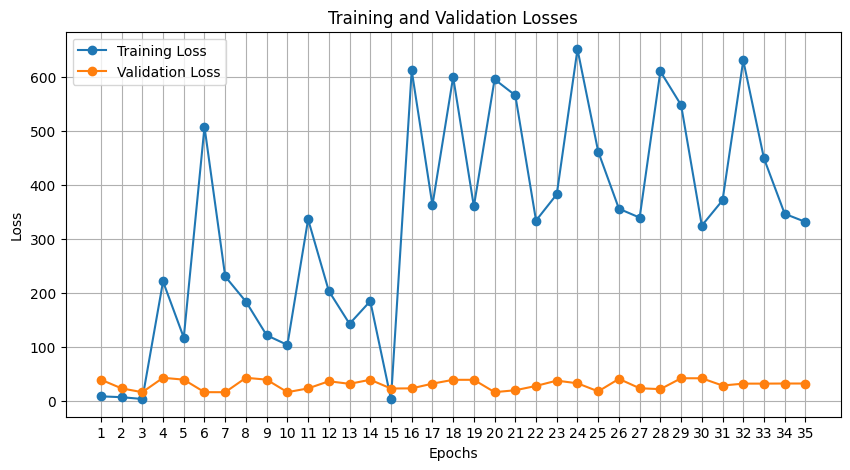

In [24]:
# Extracting training and validation losses
training_losses = torch.tensor(hist[0]).numpy().flatten()
validation_losses = torch.tensor(hist[1]).numpy().flatten()

# Get the minimum length to avoid the ValueError
min_length = min(len(training_losses), len(validation_losses))

# Trim both lists to the minimum length
training_losses_trimmed = training_losses[:min_length]
validation_losses_trimmed = validation_losses[:min_length]

# Number of epochs (should match the trimmed lists)
epochs = range(1, min_length + 1)

# Create a line plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_losses_trimmed, marker='o', linestyle='-', label='Training Loss')
plt.plot(epochs, validation_losses_trimmed, marker='o', linestyle='-', label='Validation Loss')

# Adding titles and labels
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.xticks(epochs)  # Set x-ticks to match the epochs
plt.show()

In [25]:
import winsound

# Frequency (Hz) and duration (ms)
frequency = 1000  # Set frequency to 1000 Hz
duration = 500    # Set duration to 500 ms

# Play the sound
winsound.Beep(frequency, duration)

In [26]:
torch.save(transformer.state_dict(), f'experiments/ViT{file_num + 1}.pth')

In [27]:
transformer.to(device)
transformer.load_state_dict(torch.load(f"experiments/ViT{file_num+1}.pth"))
transformer.eval()

VisionTransformer(
  (patch_embedding): PatchEmbedding(
    (linear_project): Conv2d(1, 2, kernel_size=(2, 2), stride=(2, 2))
  )
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): Sequential(
    (0): TransformerEncoder(
      (ln1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (W_o): Linear(in_features=2, out_features=2, bias=True)
        (heads): ModuleList(
          (0-1): 2 x AttentionHead(
            (query): Linear(in_features=2, out_features=1, bias=True)
            (key): Linear(in_features=2, out_features=1, bias=True)
            (value): Linear(in_features=2, out_features=1, bias=True)
          )
        )
      )
      (ln2): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=2, out_features=8, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=8, out_features=2, bias=True)
      )
    )
    (1): TransformerEncoder

In [28]:
def predict(model, image, mask):
    model.eval()
    
    with torch.no_grad():
        image = image.to(device)
        output = model(images = image, mask = mask)
        output = F.interpolate(output, size=img_size, mode='bilinear', align_corners=False)
        prediction = torch.argmax(output, dim=1)
        
    return prediction.cpu().numpy()

In [29]:
for i, data in enumerate(val_loader):
    print(data)

(tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],



        [[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],



        [[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],



        ...,



        [[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...

In [30]:
val_loss = 0.0
length = len(val_loader)
case = 0 
predictions = []
with torch.no_grad():
    for i, val_batch in tqdm(enumerate(val_loader, 0)):
        num_slices = len(val_batch[1])#Number of slces
        one_case = []#This is where we store every slice of the case 
        case_number = re.search(r'sub-(\d+)', val_batch[2][0]).group(1) # Extract the case number
        one_case.append(case_number)
        slice_list = []

        # slices_images = [] #This is where we store the images of the slices
        # slices_predictions = [] #This is where we store the predictions of the slices
        # slices_true_labels = [] #This is where we store the true labels of the slices

        print(f'Case: {case_number}')
        if num_slices != len(val_batch[0]):
            print('Not equal Number of slices:', num_slices, val_batch[0])#Checks if the number of slices of the MRI and the mask are the same
            break
        for j in range(num_slices):
            prediction_data = []#This is where we store the data of the slice predictions that will be appended to the slices_predictions list
            slice_data = []
            bounding_boxes = dataset.extract_bounding_boxes(val_batch[1][j][0].numpy())#Extracts all the bounding boxes of the slice
            cropped_images = []
            cropped_labels = []
            coordinates = []
            if len(bounding_boxes) > 0: # If there are no bounding boxes then it will skip the slice
                print('No bounding boxes found on slice ', j)
                
                for bbox in bounding_boxes: #For each bounding box it will crop the image and the label based on the given 
                    print(f"Slice {j} | ", bbox)
                    print(val_batch[0][j][0].shape)
                    cropped_images.append(
                        dataset.get_cropped_locations(
                            img = val_batch[0], 
                            x_min=bbox[0],
                            y_min=bbox[1],
                            x_max=bbox[2],
                            y_max=bbox[3]
                        ))
                    cropped_labels.append(
                        dataset.get_cropped_locations(
                            img = val_batch[1], 
                            x_min=bbox[0],
                            y_min=bbox[1],
                            x_max=bbox[2],
                            y_max=bbox[3]
                        ))
                    coordinates.append(bbox)
                if len(cropped_images[0][0][0]) != len(cropped_labels[0][0]):## Checks if the number of cropped images and labels are the same
                    print('Not equal cropped images and labels')
                    break
                # TODO: Improve this method since the method requires all the slices therefore it is needed to have another loop that checks if the extracted region has a cmb or not before feeding it into the model
                # print('Cropped Images length:', len(cropped_images))
                # print('Cropped Labels length:', len(cropped_labels))
                # print('Cropped Images number of slices:', len(cropped_images[0][0][0]))
                # print('Cropped Labels number of slices:', len(cropped_labels[0][0]))
                for k, cmb in enumerate(cropped_labels[0]):# Access the CMB labels array the n checks if there are CMBs on the slice of the case
                    for l, cmb_slice in enumerate(cmb):
                        if torch.unique(cmb_slice).numel() > 1:
                            one_cmb = []
                            # print('Predicting CMB with coordinates: ', coordinates[k])
                            # print(cmb_slice.shape)
                            # print(cropped_images[0][0][0][l].shape)
                            
                            # Enable ths method to visually see what is feeded on the model
                            # print_image(cropped_images[0][0][0][l], f'MRI Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                            # print_image(cmb_slice, f'Mask Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                            print(f'Predicting on Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                            inputs = cropped_images[0][0][0][l].unsqueeze(0).unsqueeze(0).to(device)
                            labels = cropped_labels[0][0][l].unsqueeze(0).to(device)
                            # print("Feeded inputs shape: ",inputs.shape)
                            # print("Feeded mask shape: ",labels.shape)
                            predicted_mask = predict(transformer, image = inputs.float(), mask = labels.float())
                            # print("Output shape: ",predicted_mask.shape)

                            one_cmb.append(predicted_mask[0])
                            one_cmb.append(cmb_slice)
                            one_cmb.append(coordinates[k])
                            prediction_data.append(one_cmb)
                            # print_image(predicted_mask[0], f'Predicted Mask Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                            # print_image(cmb_slice, f'Ground Truth Mask Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')

            slice_data.append(j)
            slice_data.append(val_batch[0][j][0])
            slice_data.append(prediction_data)
            slice_data.append(val_batch[1][j][0])
            slice_list.append(slice_data)
            
            print("image shape append: ", val_batch[0][j].shape)
        # print("Images", slices_images)
        # print("Appended images: ", len(slices_images))

        one_case.append(slice_list)
        predictions.append(one_case)



2it [00:01,  1.39it/s]

Case: 204
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 5

3it [00:03,  1.19s/it]

image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])


4it [00:04,  1.34s/it]

Case: 230
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 5

5it [00:05,  1.06it/s]

Predicting on Case 302 Slice 22 CMB coordinates [366, 186, 374, 194]
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.9723, device='cuda:0')
Predicting on Case 302 Slice 23 CMB coordinates [366, 186, 374, 194]
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(0.7348, device='cuda:0')
Predicting on Case 302 Slice 24 CMB coordinates [366, 186, 374, 194]
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.0342, device='cuda:0')
image shape append:  torch.Size([1, 1, 512, 512])
No bounding boxes found on slice  24
Slice 24 |  [366, 186, 372, 192]
torch.Size([1, 512, 512])
Predicting on Case 302 Slice 22 CMB coordinates [366, 186, 

6it [00:07,  1.28s/it]

Case: 220
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 5

7it [00:07,  1.05it/s]

Case: 102
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
No bounding boxes found on slice  17
Slice 17 |  [246, 316, 255, 325]
torch.Size([1, 512, 512])
Predicting on Case 102 Slice 17 CMB coordina

8it [00:07,  1.41it/s]

image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])


9it [00:09,  1.07s/it]

Case: 229
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 5

10it [00:09,  1.25it/s]

Case: 305
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
No bounding boxes found on slice  3
Slice 3 |  [262, 166, 266, 170]
torch.Size([1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
No bounding boxes found on slice  12
Slice 12 |  [110, 298, 116, 304]
torch.Size([1, 512, 512])
Predicting on Case 305 Slice 13 CMB coordinates [110, 298, 116, 304]
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: t

11it [00:11,  1.09s/it]

Case: 205
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 5

12it [00:13,  1.35s/it]

Case: 232
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 5

13it [00:13,  1.01it/s]

Case: 304
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 5

15it [00:15,  1.14it/s]

Case: 210
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 5

15it [00:15,  1.02s/it]


In [31]:
import torch
import matplotlib.pyplot as plt

def overlay_mask(image, mask, coordinates):
    x1, y1, x2, y2 = coordinates
    resized_mask = torch.nn.functional.interpolate(mask.unsqueeze(0).unsqueeze(0), size=(y2-y1, x2-x1), mode='nearest').squeeze()

    mask_overlay = torch.zeros_like(image)
    mask_overlay[y1:y2, x1:x2] = resized_mask

    return image, mask_overlay

def show_image(image, mask_overlay, title):
    plt.imshow(image, cmap='gray') 
    plt.imshow(mask_overlay, cmap='hot', alpha=0.5)  
    plt.title(title)
    plt.axis('off')
    plt.show()


### Switch p for predicted and t for true mask

In [32]:
mask_type = 'p'
# mask_type = 't'

------------Case 204---------------
Length of the whole case:  2
Case number 204
Number of slices:  192
================Case 204 Slice 0================
Slice 0
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 204 Slice 1================
Slice 1
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 204 Slice 2================
Slice 2
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 204 Slice 3================
Slice 3
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 204 Slice 4================
Slice 4
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 204 Slice 5================
Slice 5
Image shape:  torch.Size([1, 512, 

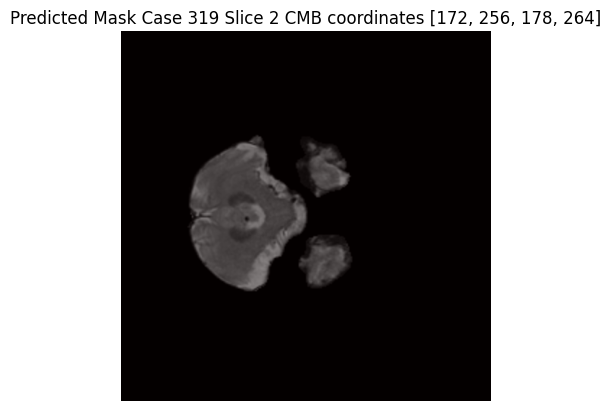

================Case 319 Slice 3================
Slice 3
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 319 Slice 4================
Slice 4
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 319 Slice 5================
Slice 5
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 319 Slice 6================
Slice 6
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 319 Slice 7================
Slice 7
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 319 Slice 8================
Slice 8
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 319 Slice 9==

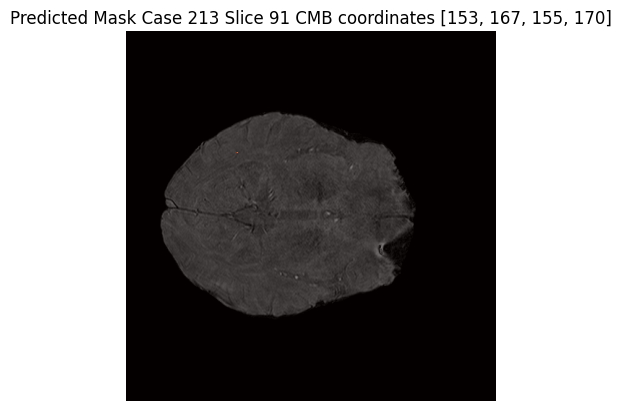

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [153, 167, 155, 170]


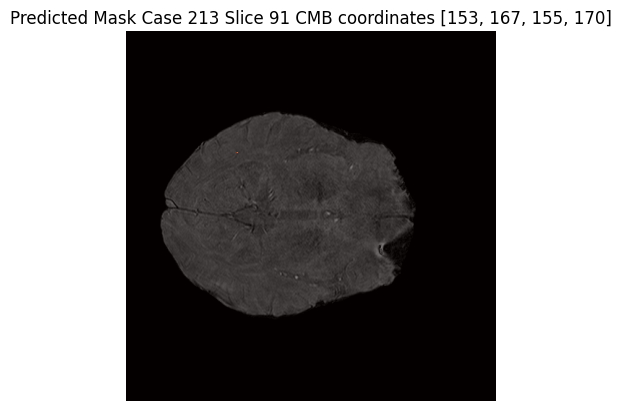

Prediction 2
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [153, 167, 155, 170]


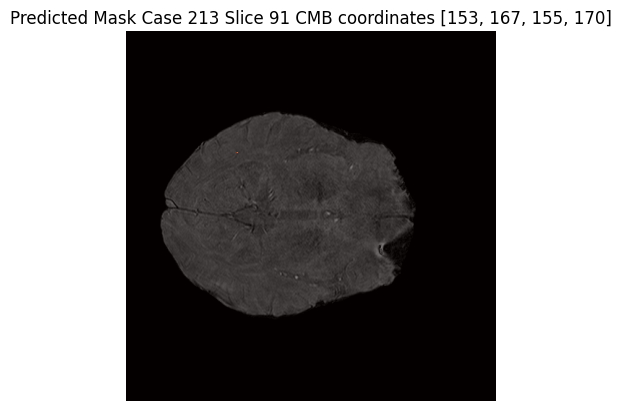

================Case 213 Slice 92================
Slice 92
Image shape:  torch.Size([1, 512, 512])
Prediction length:  3
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [153, 168, 155, 171]


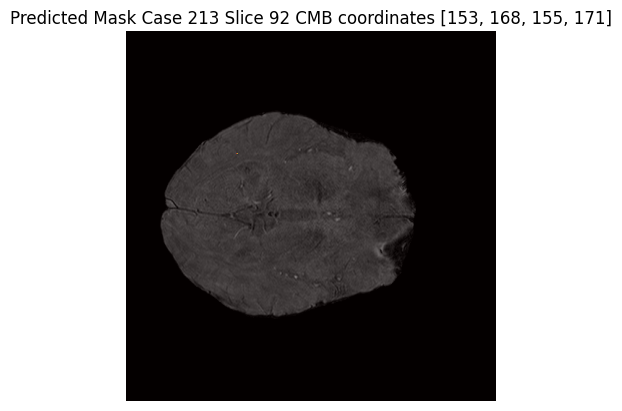

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [153, 168, 155, 171]


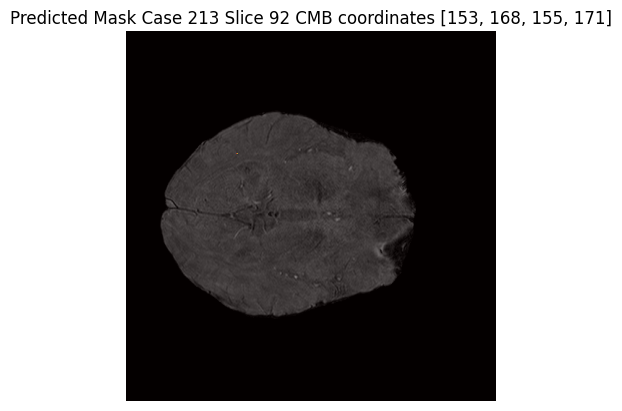

Prediction 2
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [153, 168, 155, 171]


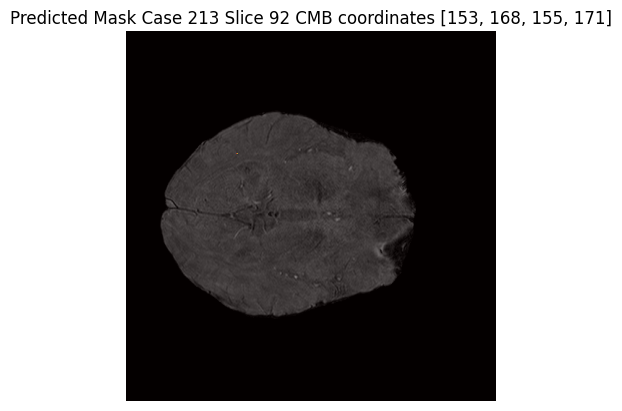

================Case 213 Slice 93================
Slice 93
Image shape:  torch.Size([1, 512, 512])
Prediction length:  3
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [153, 168, 156, 172]


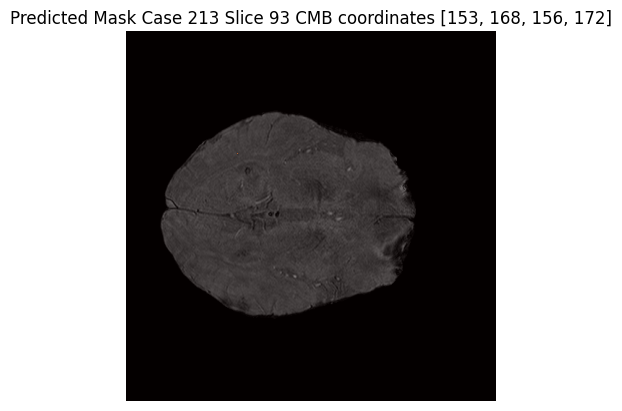

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [153, 168, 156, 172]


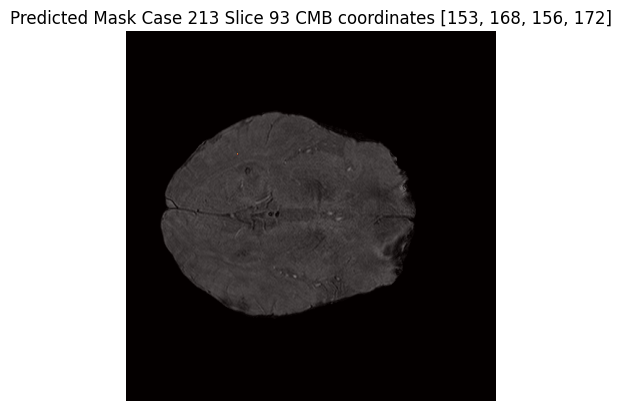

Prediction 2
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [153, 168, 156, 172]


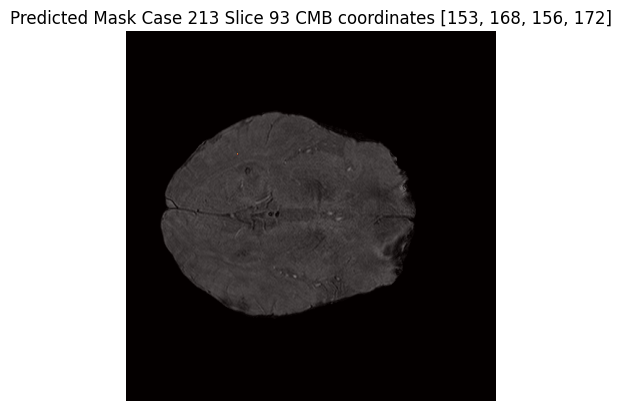

================Case 213 Slice 94================
Slice 94
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 213 Slice 95================
Slice 95
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 213 Slice 96================
Slice 96
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 213 Slice 97================
Slice 97
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 213 Slice 98================
Slice 98
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 213 Slice 99================
Slice 99
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 2

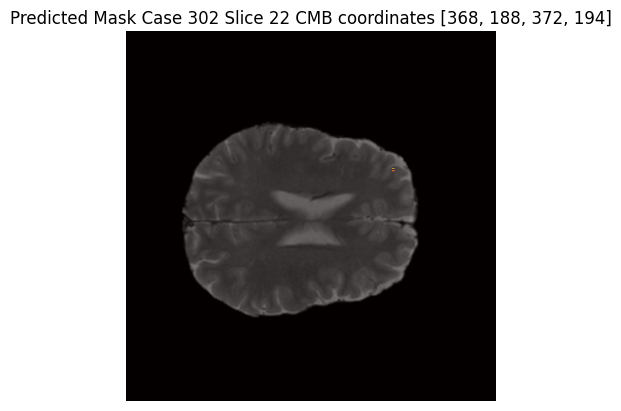

================Case 302 Slice 23================
Slice 23
Image shape:  torch.Size([1, 512, 512])
Prediction length:  3
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [366, 186, 374, 194]


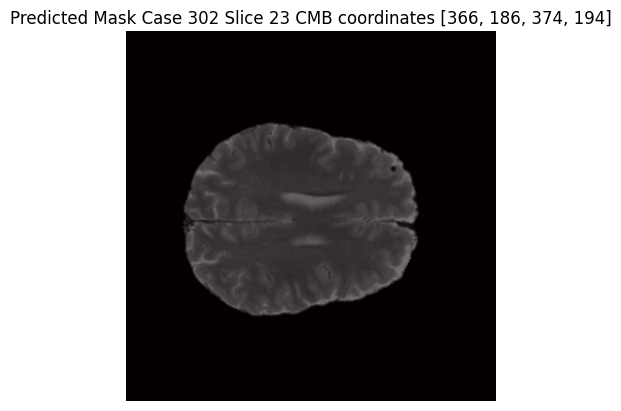

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [366, 186, 374, 194]


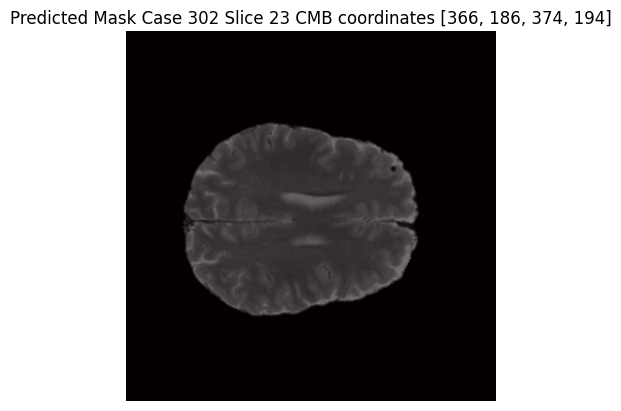

Prediction 2
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [366, 186, 374, 194]


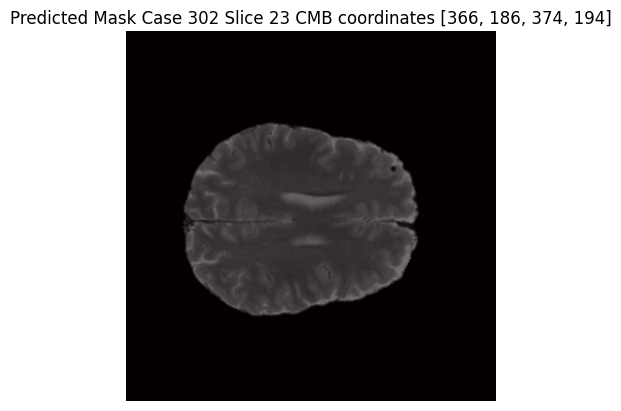

================Case 302 Slice 24================
Slice 24
Image shape:  torch.Size([1, 512, 512])
Prediction length:  3
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [366, 186, 372, 192]


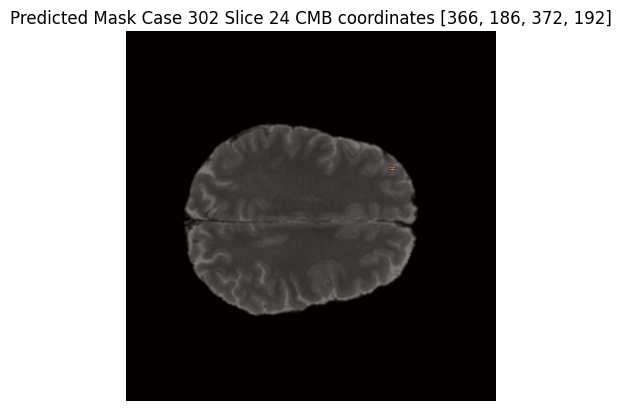

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [366, 186, 372, 192]


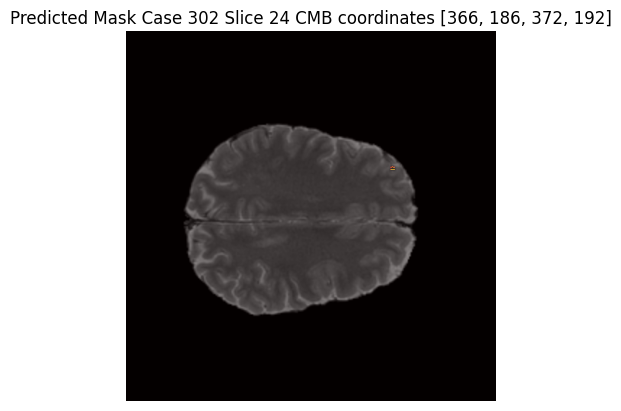

Prediction 2
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [366, 186, 372, 192]


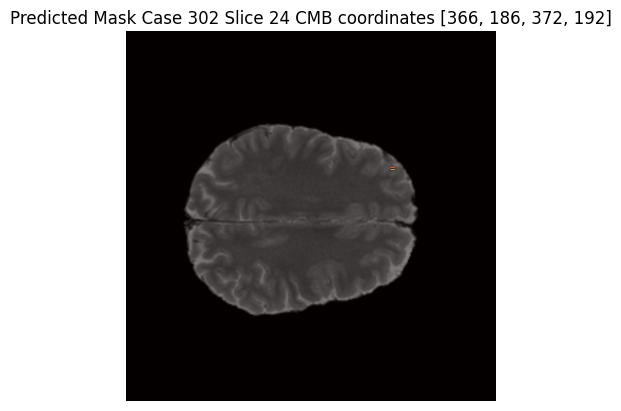

================Case 302 Slice 25================
Slice 25
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 302 Slice 26================
Slice 26
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 302 Slice 27================
Slice 27
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 302 Slice 28================
Slice 28
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 302 Slice 29================
Slice 29
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 302 Slice 30================
Slice 30
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 3

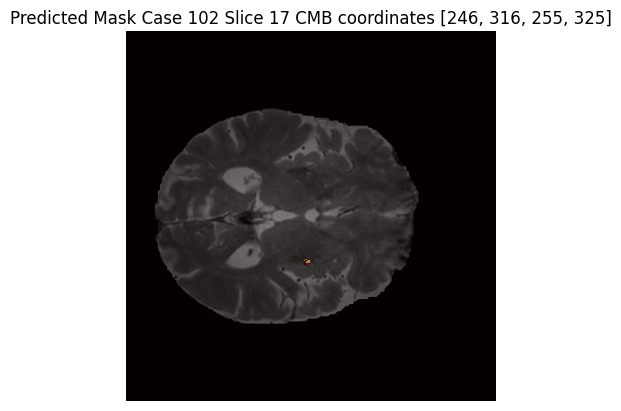

================Case 102 Slice 18================
Slice 18
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 102 Slice 19================
Slice 19
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 102 Slice 20================
Slice 20
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 102 Slice 21================
Slice 21
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 102 Slice 22================
Slice 22
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 102 Slice 23================
Slice 23
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 1

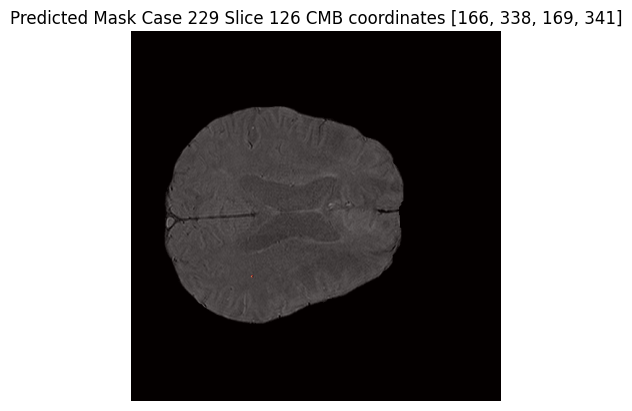

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [166, 338, 169, 341]


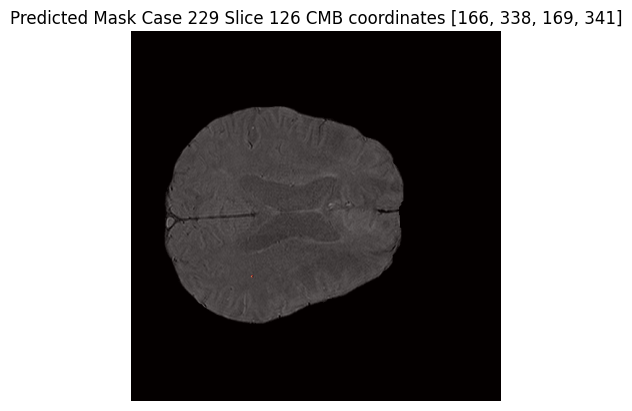

Prediction 2
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [166, 338, 169, 341]


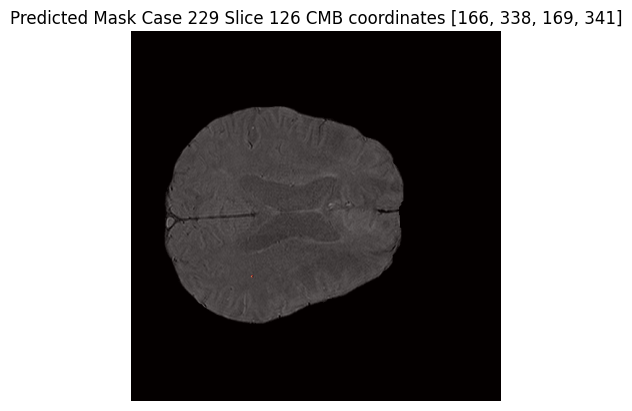

================Case 229 Slice 127================
Slice 127
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [167, 338, 169, 341]


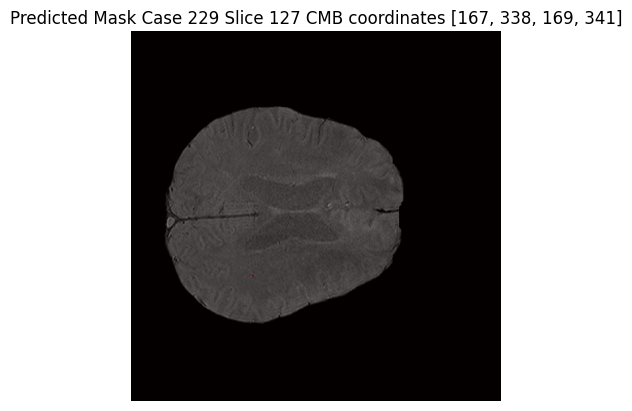

================Case 229 Slice 128================
Slice 128
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [167, 338, 169, 341]


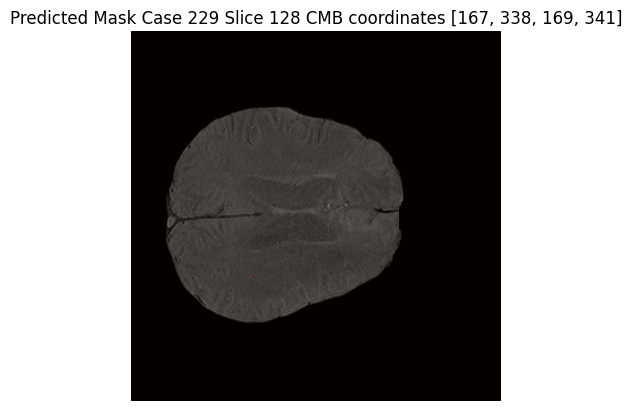

================Case 229 Slice 129================
Slice 129
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 229 Slice 130================
Slice 130
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 229 Slice 131================
Slice 131
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 229 Slice 132================
Slice 132
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 229 Slice 133================
Slice 133
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 229 Slice 134================
Slice 134
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
==========

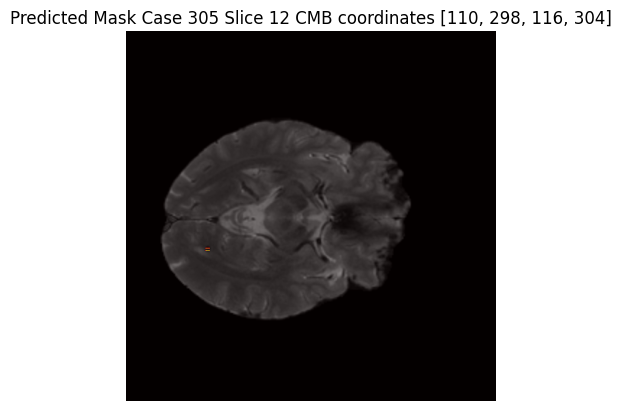

================Case 305 Slice 13================
Slice 13
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 305 Slice 14================
Slice 14
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 305 Slice 15================
Slice 15
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 305 Slice 16================
Slice 16
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 305 Slice 17================
Slice 17
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 305 Slice 18================
Slice 18
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 3

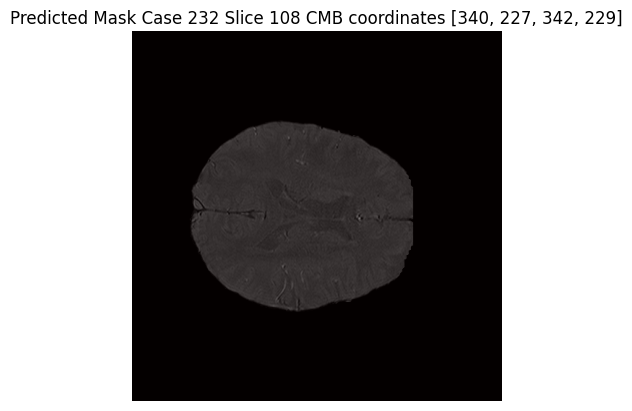

================Case 232 Slice 109================
Slice 109
Image shape:  torch.Size([1, 512, 512])
Prediction length:  4
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [339, 226, 342, 230]


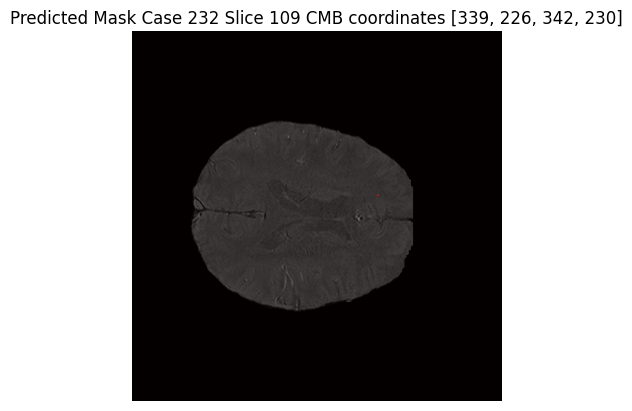

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [339, 226, 342, 230]


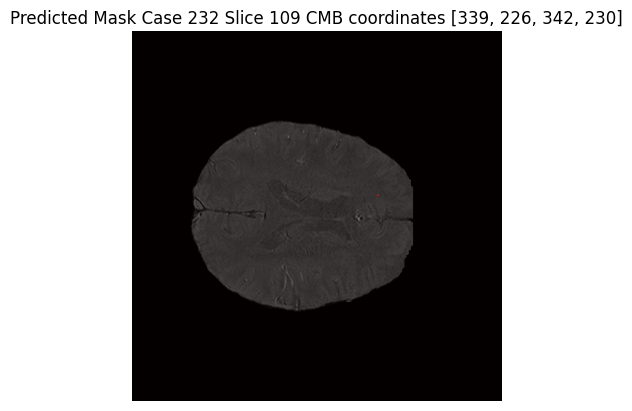

Prediction 2
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [339, 226, 342, 230]


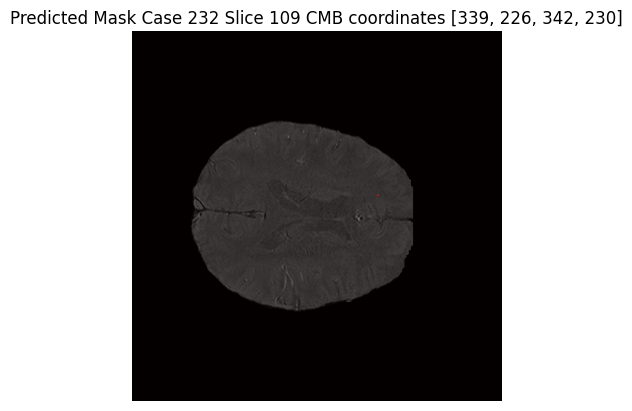

Prediction 3
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [339, 226, 342, 230]


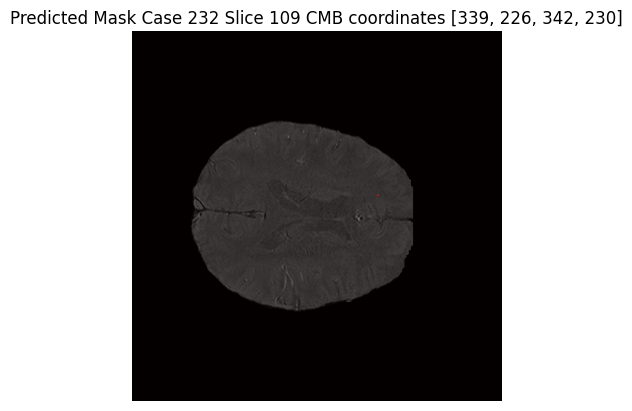

================Case 232 Slice 110================
Slice 110
Image shape:  torch.Size([1, 512, 512])
Prediction length:  4
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [339, 226, 342, 230]


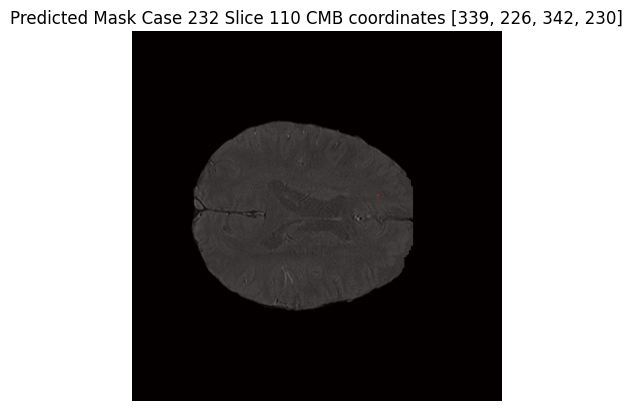

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [339, 226, 342, 230]


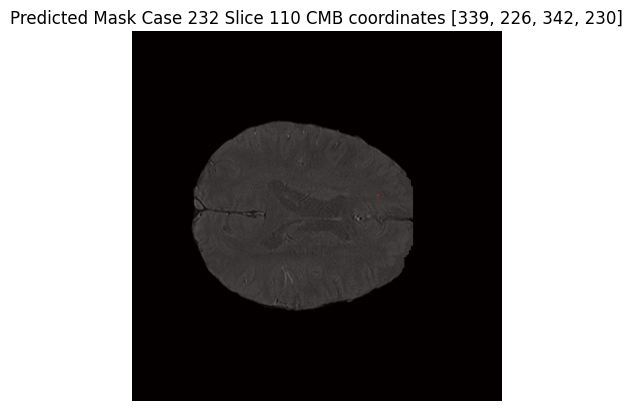

Prediction 2
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [339, 226, 342, 230]


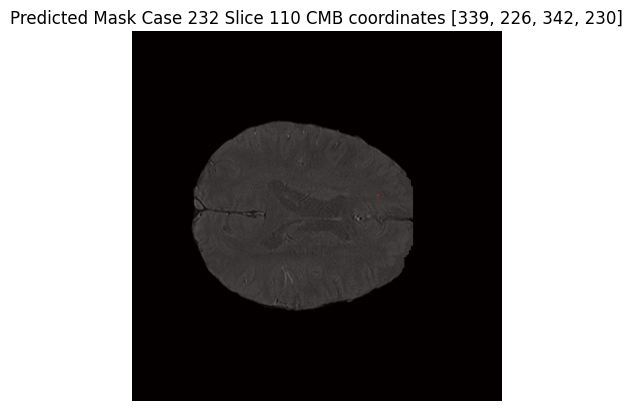

Prediction 3
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [339, 226, 342, 230]


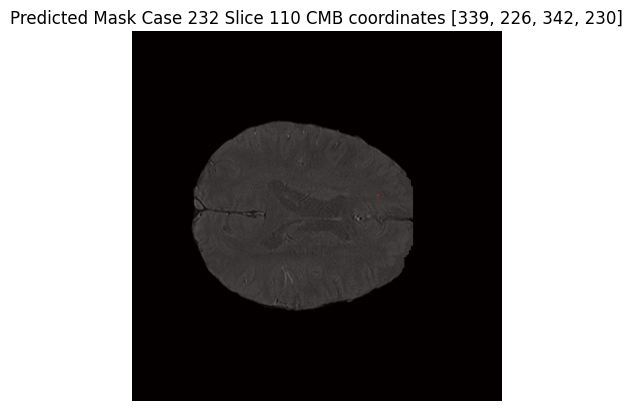

================Case 232 Slice 111================
Slice 111
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [339, 227, 341, 229]


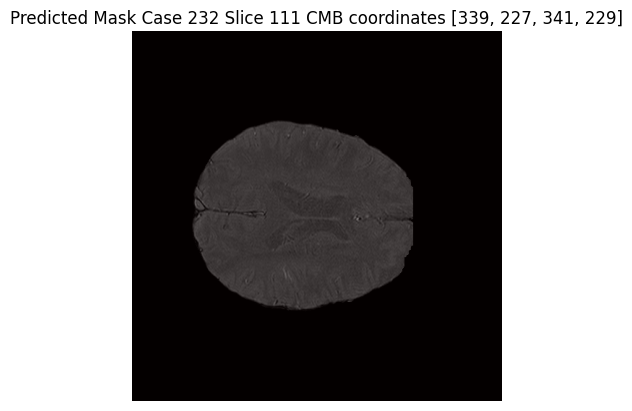

================Case 232 Slice 112================
Slice 112
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 232 Slice 113================
Slice 113
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 232 Slice 114================
Slice 114
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 232 Slice 115================
Slice 115
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 232 Slice 116================
Slice 116
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 232 Slice 117================
Slice 117
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
==========

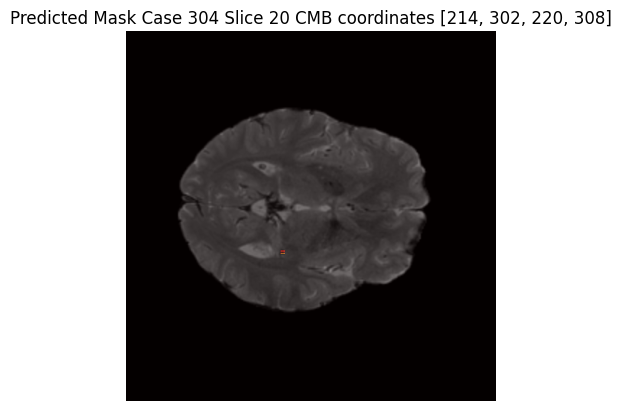

================Case 304 Slice 21================
Slice 21
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 304 Slice 22================
Slice 22
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 304 Slice 23================
Slice 23
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 304 Slice 24================
Slice 24
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 304 Slice 25================
Slice 25
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 304 Slice 26================
Slice 26
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 3

In [33]:
for case in predictions:
    case_number = case[0]
    print(f"------------Case {case_number}---------------")
    print("Length of the whole case: ", len(case))
    print("Case number", case[0])
    print("Number of slices: ", len(case[1]))

    for i, case_slice in enumerate(case[1]):
        slice_number = case_slice[0]
        print(f"================Case {case_number} Slice {slice_number}================")
        print(f"Slice {slice_number}")
        print("Image shape: ", case_slice[1].shape)
        print("Prediction length: ", len(case_slice[2]))
        print("True label shape: ", case_slice[3].shape)
        slice_image = case_slice[1][0]
        slice_prediction = case_slice[2]
        # Assuming your slice_prediction contains multiple masks
        for j, slice_pred in enumerate(slice_prediction):
            print(f"Prediction {j}")
            print("Predicted Mask shape: ", slice_pred[0].shape)
            print("True Mask shape: ", slice_pred[1].shape)
            print("Coordinates: ", slice_pred[2])
            
            predicted_mask = slice_pred[0]  
            true_mask = slice_pred[1]       
            coordinates = slice_pred[2]     
            

            predicted_mask = torch.tensor(predicted_mask, dtype=torch.float32)
            
   
            image_slice = slice_image
            
            
            if mask_type == 'p':
                image, mask_overlay = overlay_mask(image_slice, predicted_mask, coordinates)
                show_image(image, mask_overlay, f'Predicted Mask Case {case_number} Slice {slice_number} CMB coordinates {coordinates}')
            elif mask_type == 't':
                image, mask_overlay = overlay_mask(image_slice, true_mask, coordinates)
                show_image(image, mask_overlay, f'True Mask Case {case_number} Slice {slice_number} CMB coordinates {coordinates}')
            else:
                print("Invalid input! Skipping this slice.")
    # break

In [34]:
import winsound

# Frequency (Hz) and duration (ms)
frequency = 1000  # Set frequency to 1000 Hz
duration = 500    # Set duration to 500 ms

# Play the sound
winsound.Beep(frequency, duration)
winsound.Beep(frequency, duration)
winsound.Beep(frequency, duration)


In [35]:
# val_loss = 0.0
# predicted = []

# length = len(val_loader)
# case = 0 
# with torch.no_grad():
#     for i, val_batch in tqdm(enumerate(val_loader, 0)):
#         # num_slices = len(val_batch[0])
#         val_slices = []
#         one_case = []
#         val_masks = []

#         cropped_images = dataset.get_cropped_locations(img=val_batch[0], x_min=160, y_min=324, x_max=176, y_max=340)
#         cropped_labels = dataset.get_cropped_locations(img=val_batch[1], x_min=160, y_min=324, x_max=176, y_max=340)

#         num_slices = len(cropped_images)
#         for j in range(num_slices):
#             print(f'Predicting case {i} slice {j}')
#             val_images = cropped_images[j].unsqueeze(0).unsqueeze(0).float().to(device)
#             val_mask = cropped_labels[j].unsqueeze(0).float().to(device) 
            
#             predicted_mask = predict(transformer, val_images)
 
#             predicted_mask = torch.from_numpy(predicted_mask).unsqueeze(1).to(device).float()
#             predicted_mask = F.interpolate(
#                 predicted_mask, 
#                 size=img_size, 
#                 mode='nearest'
#             ).squeeze(1)

#             val_loss += criterion(predicted_mask, val_mask).item() 
#             val_slices.append(predicted_mask)
#             val_masks.append(val_mask)
            
#             print('Loss:', val_loss)
#         one_case.append(val_slices)
#         one_case.append(val_masks)
#         predicted.append(one_case)
#         case += 1

# print(f' Final Validation Loss: {val_loss}')

In [36]:
# plot_all_slices_from_array(predicted, case_index=14)

In [37]:
# plot_all_slices(masks[1])